In [1]:
import utlt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy import stats
from scipy import fftpack
from scipy.signal import find_peaks, hilbert, windows, blackman, stft
from scipy.integrate import simps
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline
from scipy.ndimage import gaussian_filter1d
from scipy.linalg import lstsq, eigh, norm
from scipy.optimize import curve_fit, nnls, leastsq, minimize, least_squares
from scipy.constants import hbar, elementary_charge, speed_of_light, Boltzmann

from itertools import product, combinations
import copy
from split_op_gpe1D import SplitOpGPE1D, imag_time_gpe1D    # class for the split operator propagation
from numba import njit

from collections import Counter
from dataclasses import dataclass

from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm


from sklearn import linear_model

import glob
import os

from datetime import datetime

threads = 16
os.environ["OMP_NUM_THREADS"] = '{}'.format(threads)
os.environ['NUMEXPR_MAX_THREADS'] = '{}'.format(threads)
os.environ['NUMEXPR_NUM_THREADS'] = '{}'.format(threads)
os.environ['OMP_NUM_THREADS'] = '{}'.format(threads)
os.environ['MKL_NUM_THREADS'] = '{}'.format(threads)

In [2]:
def order(number):
    return np.floor(np.log10(number))


def get_wide_plot(parameters=plt.rcParams):
    wide_plt_params = {
        'figure.figsize': (4, 3),
        'figure.dpi': 300,
        'legend.fontsize': 7,
        'axes.labelsize': 10,
        'axes.titlesize': 8,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'lines.linewidth': 2,
    }
    parameters.update(wide_plt_params)


def Phi(grid, wave_vector, phase=0, amplitude=1):
    return amplitude * np.sin(wave_vector * grid + phase)


def Phi_transform(time, frequency, amplitude_1, amplitude_2):
    return amplitude_1 * np.sin(frequency * time) + amplitude_2 * np.cos(frequency * time)


def Phi_combine(A, B, wave_vector, grid):
    amplitude = np.sqrt(A ** 2 + B ** 2)
    phase = np.angle(A + 1j * B)
    single_field = amplitude * np.cos(wave_vector * grid - phase)
    return amplitude, phase, single_field


def Phi_combine_amps(A, B):
    """
    Remember that A is the amplitude of the COSINE
    and B is the amplitude of the SINE
    """
    return  np.sqrt(A ** 2 + B ** 2)


def Phi_combine_phases(A, B):
    return -np.angle(A + 1j * B) + np.pi/2


def atomic_transition(x='D1'):
    """
    I hated how the code looked commenting and uncommenting so, I've simply stuck this here in initial functions
    Is this necessary? No, but also I don't care.
    """
    common_transitions = {
        'D1': 794.978851,
        'D2': 780.251210,
    }
    return common_transitions[x]


ok = utlt.standardize_plots(plt.rcParams)

In [51]:
"""
Determine the atomic transition line, D1 or D2 lines for Rb-87 are the only ones supported currently
Then, call an instance of BEC to get physical params. 
This way wavelengths may be set precisely for dimensionless units.
Additionally this cell enables polarizability calculations for translating field strength to potential amplitude.
"""

transition = 'D2'
principal_wavelength = atomic_transition(transition)
# Resonance frequency of the atomic transition in units of 2π Hz to keep units consistent,
ω_0 = 2 * np.pi * speed_of_light / principal_wavelength * 1e9
# Model parameters for dimensionless units.
ω_x = 0.5 * 2 * np.pi  # From experimental cigar length params
ω_yz = 500 * 2 * np.pi
N = 2e3

atom_params = dict(
    atom='R87',
    kicked=False,
    omega_x=ω_x,
    omega_y=ω_yz,
    omega_z=ω_yz,
    number_of_atoms=N,
)
gpe = utlt.BEC(**atom_params)
g = gpe.g


def f2V_scaling(wavelength):
    """Function to determine the scaling coefficient to translate electric field to optical potential
    It is VERY IMPORTANT to pass the wavelength in nm!!!
    """
    frequency = 2 * np.pi * speed_of_light * 1e9 / wavelength
    denominator = ω_0 ** 2 - frequency ** 2
    gfo = order(np.abs(denominator))
    denominator /= 10 ** gfo
    return -1 / denominator, (-1 * gfo)


def oldf2V_scaling(wavelength):
    """
    Function to determine the scaling coefficient to translate electric field to optical potential
    It is VERY IMPORTANT to pass the wavelength in meters!!!
    """
    frequency = 2 * np.pi * speed_of_light / wavelength 
    gfo = order(frequency)
    frequency /= 10 ** gfo
    ω0_orderless = ω_0 / 10 ** gfo
    α = 1.602176634 ** 2 / 1.4431606    # the order of magnitude, 10^-13, will be added in the next line.
    return (0.5 * α / (ω0_orderless ** 2 - frequency ** 2)), (-13 - (gfo * 2))

def two_field_combine(E1, E2, λ1, λ2):
    α1, α1_order = f2V_scaling(λ1)
    α1 *= 10 ** α1_order
    α2, α2_order = f2V_scaling(λ2)
    α2 *= 10 ** α2_order
    potential = α1 * E1 ** 2 + (α1 + α2) * (E1 * E2) + α2 * E2 ** 2
    return potential



In [4]:
"""
Define Laser Params and the simulation grid
"""
# Control Amplitudes (in nm)
λ_control = np.array([770, 780])
# Target wavelength (equal to the width of the superoscillations window)
λ_target = 0.25 * min(λ_control)
# Wavevectors in dimensionless units for computation purposes
k_target = 2 * np.pi / gpe.dimless_x(λ_target, -9)
k = 2 * np.pi * (gpe.dimless_x(λ_control, -9) ** -1)

# Set the dimensionless length of the window for superoscillations here
window = gpe.dimless_x(λ_target, -9)
# Limit the full range of pulse to the characteristic length
x_lim = gpe.dimless_x(0.5 * gpe.L_x)
x_res = 2 ** 15
dx = 2 * x_lim / x_res

x = np.arange(-window/2, window/2, dx)
x_full = np.arange(-x_lim, x_lim, dx)
x_units = gpe.convert_x(x, -9)


# Number of pulses
n = len(λ_control)
# Determine the error tolerance
eps = 1e-11
# Amplitude of target barrier
ampl = gpe.dimless_energy(600, -9)


In [5]:
named_params = {
    'tgt_wavelength': round(λ_target, 5),
    'max': round(max(λ_control), 5),
    'min': round(min(λ_control), 5),
    'step': round(max(λ_control) - min(λ_control), 5),
    'pulses': n,
}
params = copy.deepcopy(named_params)
file_path, file_name = utlt.build_saves_tag(params_list=named_params,
                                            unique_identifier=f'{transition}-Blue-TwoPulseExperiment',
                                            parent_directory='Archive_Data/Superoscilations')

Parent directory check passed! 
Results will be available in Archive_Data/Superoscilations

You may be overwriting previous data (; n;)



In [6]:
# Get the contant prefactor for α in dimensionless units.
# (elementary_charge^2 order e-38) / (mass order e-25, hbar order e-34)
# comes out to 1e-38 / 1e-59, or 1e21 after everything, round to 8 digits because of precision
α_dimless = round(1e21 * (1.602176634 ** 2 * 1.380649)/ (1.44316060 * 1.054571817 * ω_x), 8) 

In [7]:
############################################################
#
# It is important to calculate the Critical Temp for a BEC
# This ensures that simulations are actually a BEC, and not
# just wishful thinking. 
#
# T_c = (number density / ζ(3/2))^(2/3) * 2πħ^2 / m*kB
#
############################################################

# The volume in micrometers temporarily to avoid machine precision
# These changes to order of magitude are corrected for by removing orders of known quantities
# ħ = 1.054571817e-34, kB=1.380649e-23*1e-9nK/K, m_87Rb=1.4431609e-25, L_i∝1e-6, Volume∝1e-18
# (N/∝1e-18)^(2/3) → (N/orderless_volume)^(2/3)*1e12, 
# simply multiplying by orders, we get 1e12 * ((1e-34)^2 / (1e-23*1e-9*1e-25)) → 1e12 * 1e57 / 1e68 → 1e1, 10
volume = (gpe.L_x * 1e6) * (gpe.L_y * 1e6) * (gpe.L_z * 1e6)
number_density = N / volume 
ζ_32 = 2.61237534869    # Riemman Zeta function (3/2)
T_c = 10 * (number_density / ζ_32) ** (1.5) * 2 * np.pi * 1.054571817 ** 2 / (1.4431609 * 1.380649)


# Now print the parameters for the run so that simulations can guarantee T << T_c
print(f'T_c, the critical temperature, is {T_c} nK.\nThis will be checked when modeling experiment')
#print(f'The wavelength spacing is {λ_spacing * gpe.convert_x(λ_min, -9)} nm') # Not used currently
print(f'The conversion factor for dimensionless energy {gpe.dimless_energy(1, -9)}')
print(f'The target potential amplitude is {round(gpe.convert_energy(ampl ** 2, -9), 2)} nK, or ~{round(ampl ** 2, 2)} in dimensionless units.')
print(f'The characteristic length, L_x is {gpe.L_x *1e6} μm')
print(f'The transverse characteristic length, L_y, L_z is {gpe.L_y *1e6} μm')
print(f'The shortest wavelength for this for this run is {min(λ_control)} nm')

T_c, the critical temperature, is 111185.92893691169 nK.
This will be checked when modeling experiment
The conversion factor for dimensionless energy 41.67323824665515
The target potential amplitude is 15002365.77 nK, or ~625197162.95 in dimensionless units.
The characteristic length, L_x is 15.25126148743101 μm
The transverse characteristic length, L_y, L_z is 0.48228723491089454 μm
The shortest wavelength for this for this run is 770 nm


In [46]:
target_barrier = Phi(x, k_target, amplitude = ampl, phase=-np.pi/2)   
f2V_scaling(min(λ_control))

-1.5621689443385993e+29


(0.6401356291354173, -29.0)

In [9]:
##############################################
#
# Get the initial guesses for the optimization
#
##############################################

# New array for time
# Set
workers = 64
# Number of initial guesses per thread
init_guess_n = workers * 20


seed = np.random.default_rng(2024)
# Create the array of variables for the initial guess
initial_guess = np.hstack([
    # Phase
    seed.uniform(-2*np.pi, 2*np.pi, (init_guess_n, n)),
    # Amplitudes
    seed.uniform(1, ampl*1e3, (init_guess_n, n))
])

freqs = k

print('Number of Pulses: {}'.format(n))
#initial_guess = np.array([20, 0, 0, 1])

print('Length of x: ' + str(len(initial_guess)))

print(f'Wavevectors are: {freqs}')
print(f'Wavelengths are: {λ_control} (nm)')

# Define the constraints
phase_lims = (-2 * np.pi, 2 * np.pi)           # Time delay constrained to be positive
ampl_lims = (0, None)      # Some constraints for amplitude


# Create the array of bounds for the best fit minimization
bnds = np.concatenate([
    # Phase limits
    np.full((n, 2), phase_lims),
    # Amplitude limits
    np.full((n, 2), ampl_lims)
])

initial_guess_alt = np.hstack([
    # Phase
    seed.uniform(1, 20, (init_guess_n, n)),
    # Amplitudes
    seed.uniform(1, 20, (init_guess_n, n))
])

# Define the constraints
ai_lims = (0, None)
bi_lims = (0, None)


# Create the array of bounds for the best fit minimization
bnds_alt = np.concatenate([
    # Phase limits
    np.full((n, 2), ai_lims),
    # Amplitude limits
    np.full((n, 2), bi_lims)
])


Number of Pulses: 2
Length of x: 1280
Wavevectors are: [124.45000272 122.85448986]
Wavelengths are: [770 780] (nm)


In [10]:
#######################################
#
# Define Functions for fitting
#
#######################################


def unpack(f):
    # Ensure that the array is equally divisible by number of parameters
    length, res = divmod(len(f), 2)
    assert res == 0
    phases = f[:length]
    amplitudes = f[length:(2 * length)]
    
    return phases, amplitudes

def phi_func(f, t):
    phase, amplitude = unpack(f)
    # Smart way of doing it keeps failing, so do it the very dumb way
    return sum(Phi(t, i, j, k) for i, j, k in zip(freqs, phase, amplitude))

def obj(f):
    """
    Minimizes norm of the difference between  target tracking field and the SFC
    """
    #result = least_squares(lambda z: phi_func(z) - tracking_phi, x)
    #return result.cost, result.x
    #print("bounds length: " + str(len(bnds)) + " and x length: " + str(len(x)) + "\n")
    result = minimize(
        lambda z: np.linalg.norm(phi_func(z, x) - target_barrier) ** 2, 
        f,
        bounds=bnds,
        tol=eps
    )
    return result.fun, result.x



def phi_func_alt(f, t):
    ai, bi = unpack(f)
    # Smart way of doing it keeps failing, so do it the very dumb way
    return sum(Phi_transform(t, i, j, k) for i, j, k in zip(freqs, ai, bi))

def obj_alt(f):
    """
    Minimizes norm of the difference between  target tracking field and the SFC
    """
    #result = least_squares(lambda z: phi_func(z) - tracking_phi, x)
    #return result.cost, result.x
    #print("bounds length: " + str(len(bnds)) + " and x length: " + str(len(x)) + "\n")
    result = minimize(
        lambda z: np.linalg.norm(phi_func_alt(z, x) - target_barrier) ** 2, 
        f,
        bounds=bnds_alt,
        tol=eps
    )
    return result.fun, result.x



In [11]:
def super_obj(f):
    """
    Minimizes norm of the difference between  target tracking field and the SFC
    """
    #result = least_squares(lambda z: phi_func(z) - tracking_phi, x)
    #return result.cost, result.x
    #print("bounds length: " + str(len(bnds)) + " and x length: " + str(len(x)) + "\n")
    result = minimize(
        lambda z: np.linalg.norm(phi_func(z, x)) ** 2, 
        f,
        bounds=bnds,
        tol=eps
    )
    return result.fun, result.x

## Fitting using superoscillations begins here

In [12]:
#########################################################################
#
# Fitting the fields by optimizing the frequencies, delays, and streches
# Uses Parallel computing to find best results
#
#########################################################################

if __name__ == '__main__':
    with Pool(processes=workers) as pool:
        result = pool.map(obj, initial_guess)
        #result_super = pool.map(super_obj, initial_guess)
        #result_alt = pool.map(obj_alt, initial_guess_alt)

Amplitudes here are: [7135238.96913864 7115942.40837852]


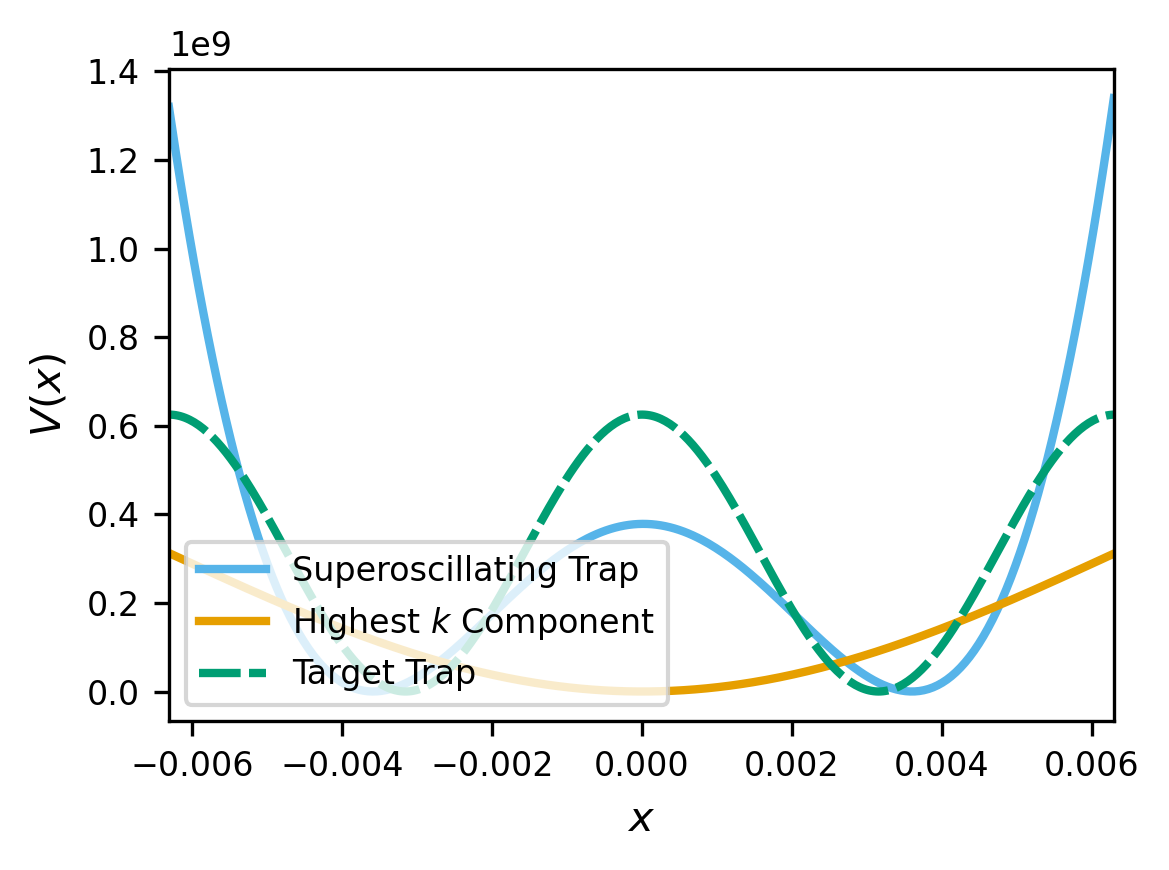

In [13]:
############################################################
#
# Get the best result for minimization of objective function
#
############################################################

result.sort(key=lambda _: _[0])
opt_vals = result[0][1]
best_fit = phi_func(opt_vals, x)
best_fit_phases, best_fit_amps = unpack(opt_vals)
print(f'Amplitudes here are: {best_fit_amps}')
#print(f'Prefactors for each field are: {f2V_scaling(gpe.convert_x(λ_array, 0))}')

plt.plot(x, best_fit ** 2 , label='Superoscillating Trap')
plt.plot(x, np.abs(Phi(x, max(k), amplitude=ampl)) ** 2, label='Highest $k$ Component')
plt.plot(x, target_barrier ** 2 , linestyle=(0, (5, 1)), label='Target Trap')
plt.xlabel('$x$')
plt.ylabel('$ V(x)$')
plt.xlim(x[0], x[-1])
#plt.ylim(0, 1.1*ampl**2)
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results.pdf')
#plt.savefig('./Plots/Presentation/Results.pdf')
plt.show()

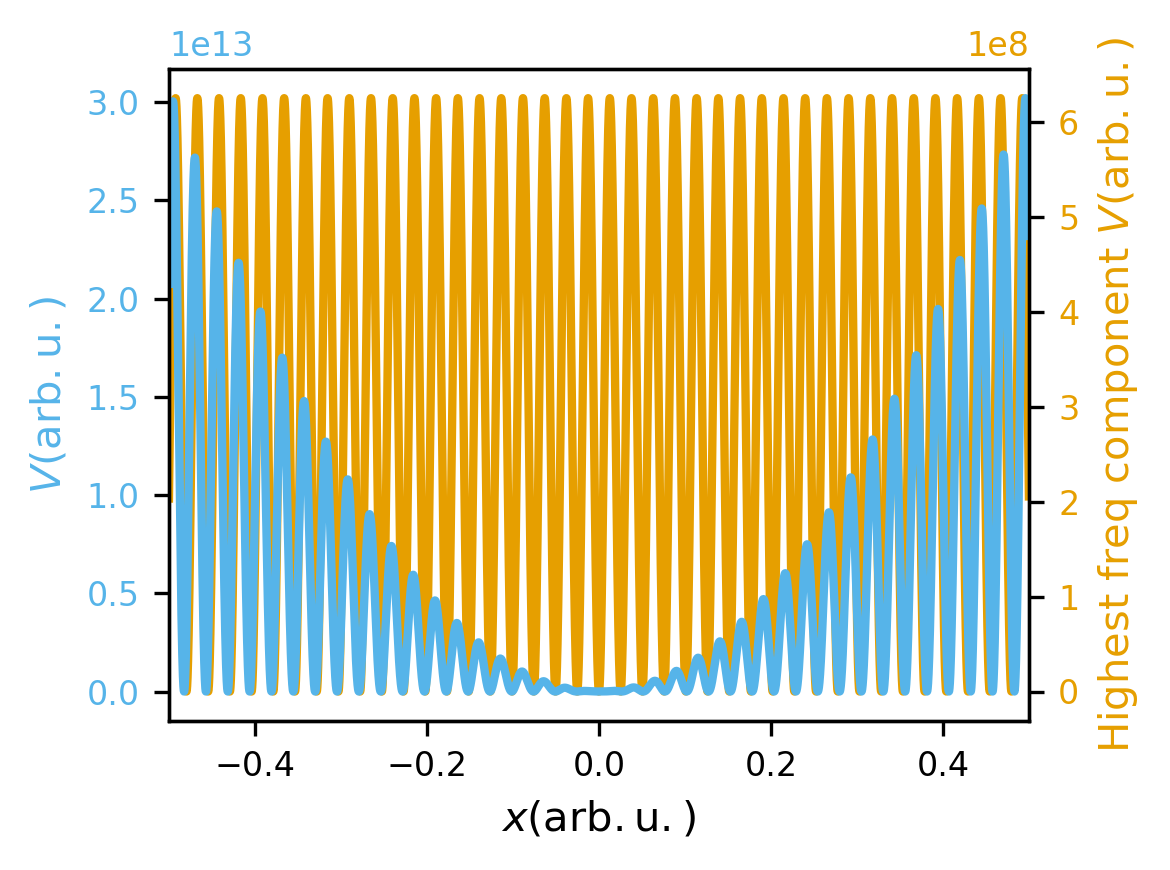

In [14]:
############################################################
#
# Show the complete potential
#
############################################################

best_fit_zoom = phi_func(opt_vals, x_full)
c1 = ok['blue']
c2 = ok['orange']

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(x_full, best_fit_zoom ** 2, label='Superoscillating Trap', color=c1)

ax2=ax1.twinx()
ax2.plot(x_full, Phi(x_full, max(k), amplitude=ampl) ** 2, label='Highest Frequency Component', color=c2)

ax1.tick_params('y', labelcolor=c1)
ax2.tick_params('y', labelcolor=c2)
ax1.set_xlabel('$x {\\rm (arb. u.)}$')
ax1.set_ylabel('$V {\\rm (arb. u.)}$', color=c1)
ax2.set_ylabel('Highest freq component $V {\\rm (arb. u.)}$', color=c2)
ax1.set_xlim(x_full[0], x_full[-1])

ax1.set_zorder(1)
ax1.patch.set_visible(False)
#plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ResultsZoomed.pdf')
#plt.savefig('./Plots/Presentation/ResultsZoomed.pdf')
plt.show()

In [15]:
#########################################################################
#
# Fitting the fields by linear model, as it can be convexly solved
#
#########################################################################
fields = np.array([
    Phi(x, i, j) for i, j in product(freqs, [0, np.pi/2])
]).T

fields_zoomed = np.array([
    Phi(x_full, i, j) for i, j in product(freqs, [0, np.pi/2])
]).T

#model = linear_model.Lasso(alpha=0.0001, fit_intercept=False, tol=1e-6, max_iter=100000)
#model = linear_model.Ridge(fit_intercept=False, tol=1e-6, max_iter=100000)
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(fields, target_barrier)

linear_optimized_fields = fields @ model.coef_
lo_fields_zoom = fields_zoomed @ model.coef_

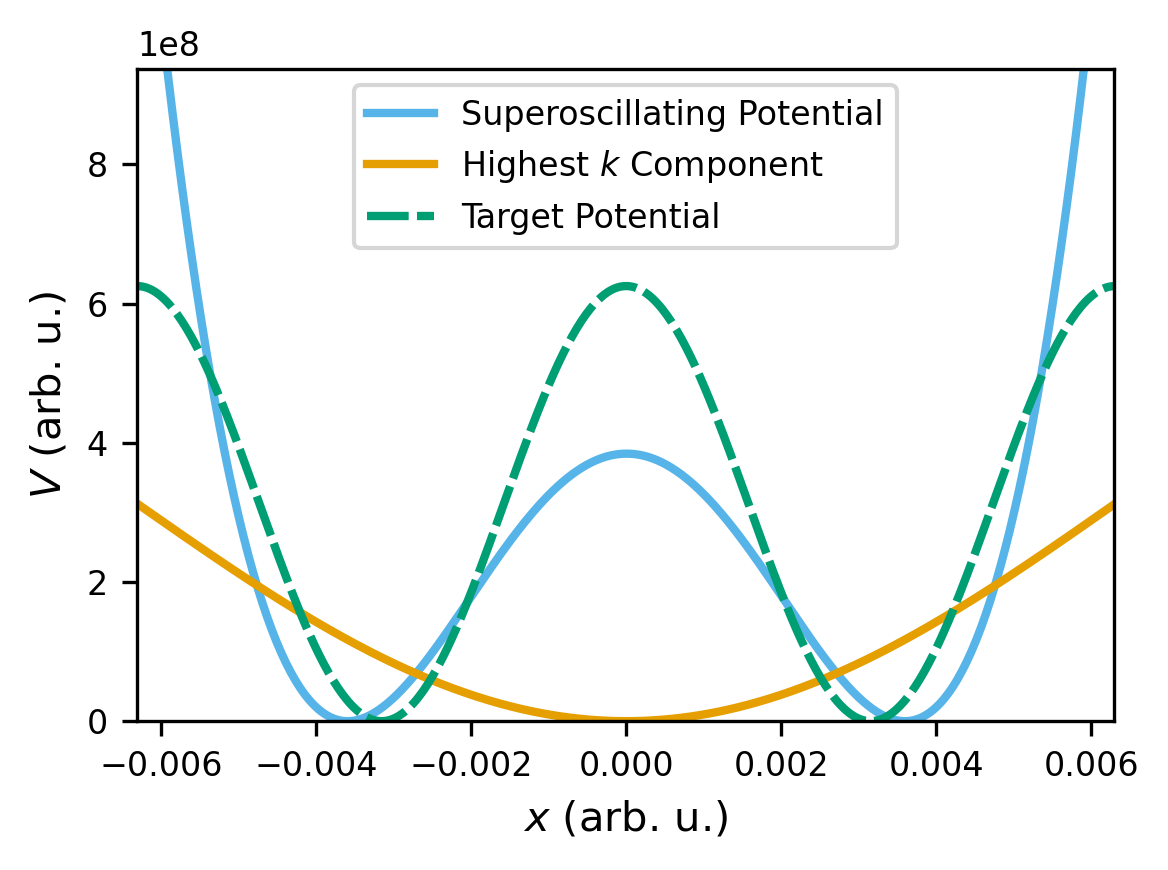

In [16]:
############################################################################
#
# Plot the results for linear optimization
#
############################################################################
plt.plot(x, np.abs(linear_optimized_fields) ** 2, label='Superoscillating Potential')
plt.plot(x, np.abs(Phi(x, max(k), amplitude=ampl, phase=0)) ** 2, label='Highest $k$ Component')
plt.plot(x, np.abs(target_barrier) ** 2, linestyle=(0, (5, 1)), label='Target Potential')
plt.xlabel('$x$ (arb. u.)')
plt.ylabel('$V$ (arb. u.)')
plt.xlim(x[0], x[-1])
plt.ylim(-0.025, 1.5*ampl**2)
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_linear.pdf')

plt.show()



In [17]:
############################################################################
#
# Get the amplitudes of the fields used to see if they are realistic
#
############################################################################

single_func_amps = [Phi_combine_amps(model.coef_[_+1], model.coef_[_]) for _ in np.arange(0, len(model.coef_), 2)]
single_func_phase = [Phi_combine_phases(model.coef_[_+1], model.coef_[_]) for _ in np.arange(0, len(model.coef_), 2)]
simplified_fields = [Phi(x_full, freqs[_], phase=single_func_phase[_], amplitude= single_func_amps[_]) for _ in range(len(freqs))]
print(f'Individual amplitudes are {model.coef_}')
print(f'Dimensionless amplitudes are {single_func_amps}')
print(f'Phases are {single_func_phase}')

#plt.plot(x_full, lo_fields_zoom, label='Comparrison Field')
#plt.plot(x_full, np.sum(simplified_fields, axis=0), '--', label='Simplified Field')
#plt.xlabel('$x$')
#plt.ylabel('$ V(x)$')
#plt.xlim(x_full[0], x_full[-1])
#plt.legend(loc='upper center')
#plt.tight_layout()
#plt.show()


Individual amplitudes are [ -146732.89126228 -7183402.47940371   148471.11901377  7163796.64015245]
Dimensionless amplitudes are [7184900.954256894, 7165335.0218005]
Phases are [4.69196516468241, 1.5500740932986699]


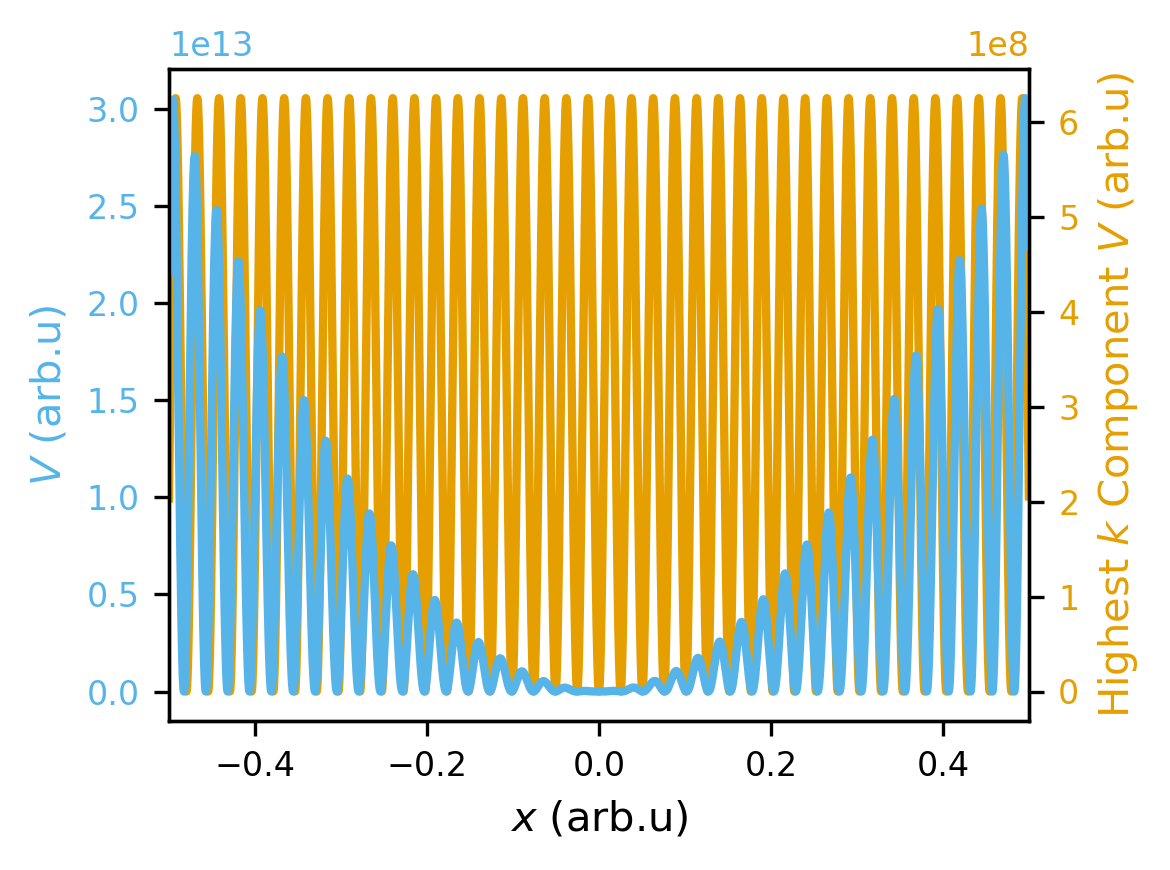

In [18]:
############################################################################
#
# Plot the zoom out of the results for linear optimization
#
############################################################################

c1 = ok['blue']
c2 = ok['orange']

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(x_full, np.abs(lo_fields_zoom) ** 2, label='Superoscillating Potential', color=c1)

ax2=ax1.twinx()
ax2.plot(x_full, np.abs(Phi(x_full, max(k), amplitude=ampl)) ** 2, label='Highest $k$ Component', color=c2)

ax1.tick_params('y', labelcolor=c1)
ax2.tick_params('y', labelcolor=c2)
ax1.set_xlabel('$x$ (arb.u)')
ax1.set_ylabel('$V$ (arb.u)', color=c1)
ax2.set_ylabel('Highest $k$ Component $V$ (arb.u)', color=c2)
ax1.set_xlim(-x_lim, x_lim)

ax1.set_zorder(1)
ax1.patch.set_visible(False)

plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_linearZoomed.pdf')
#plt.savefig('./Plots/Presentation/Results_linearZoomed.pdf')
plt.show()

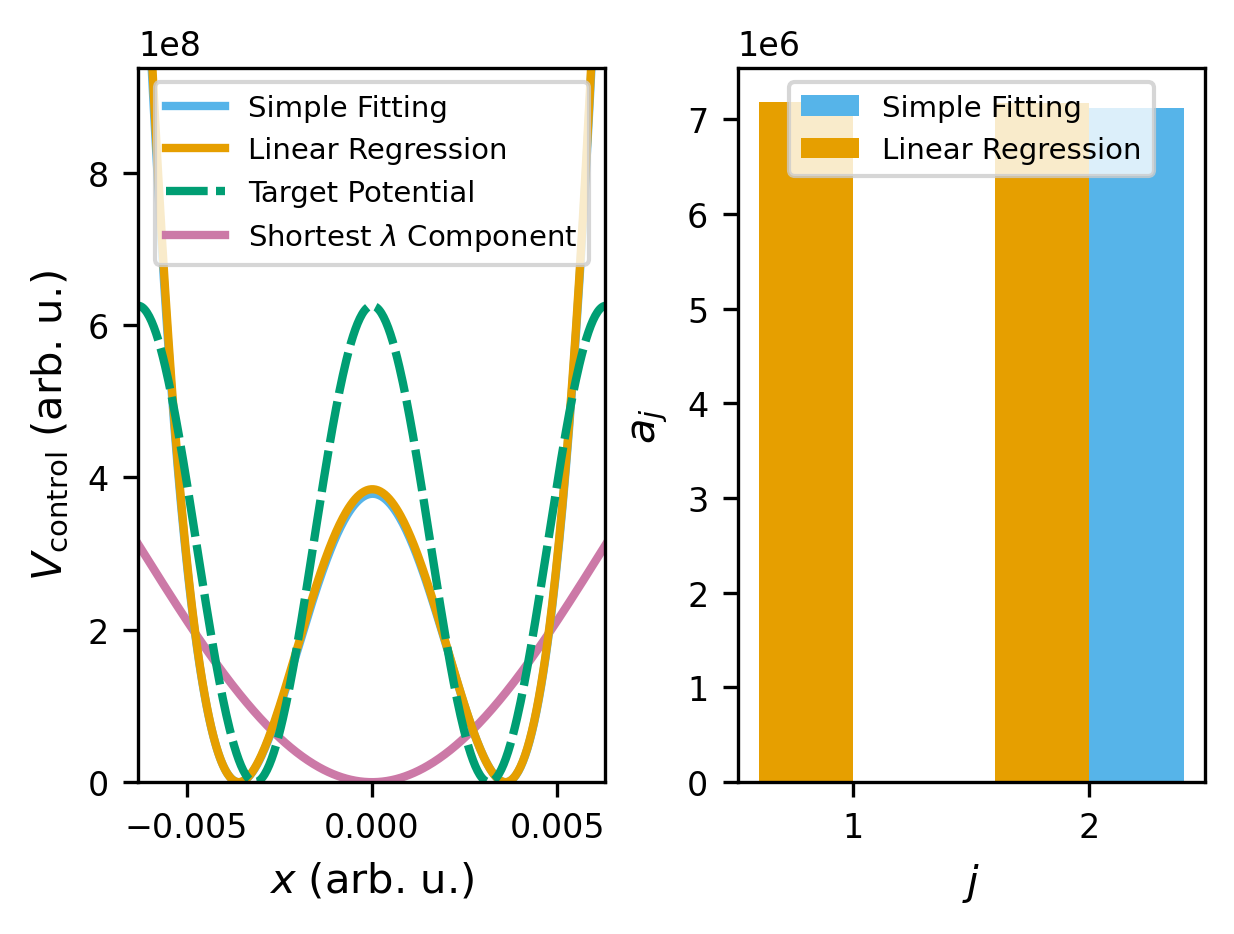

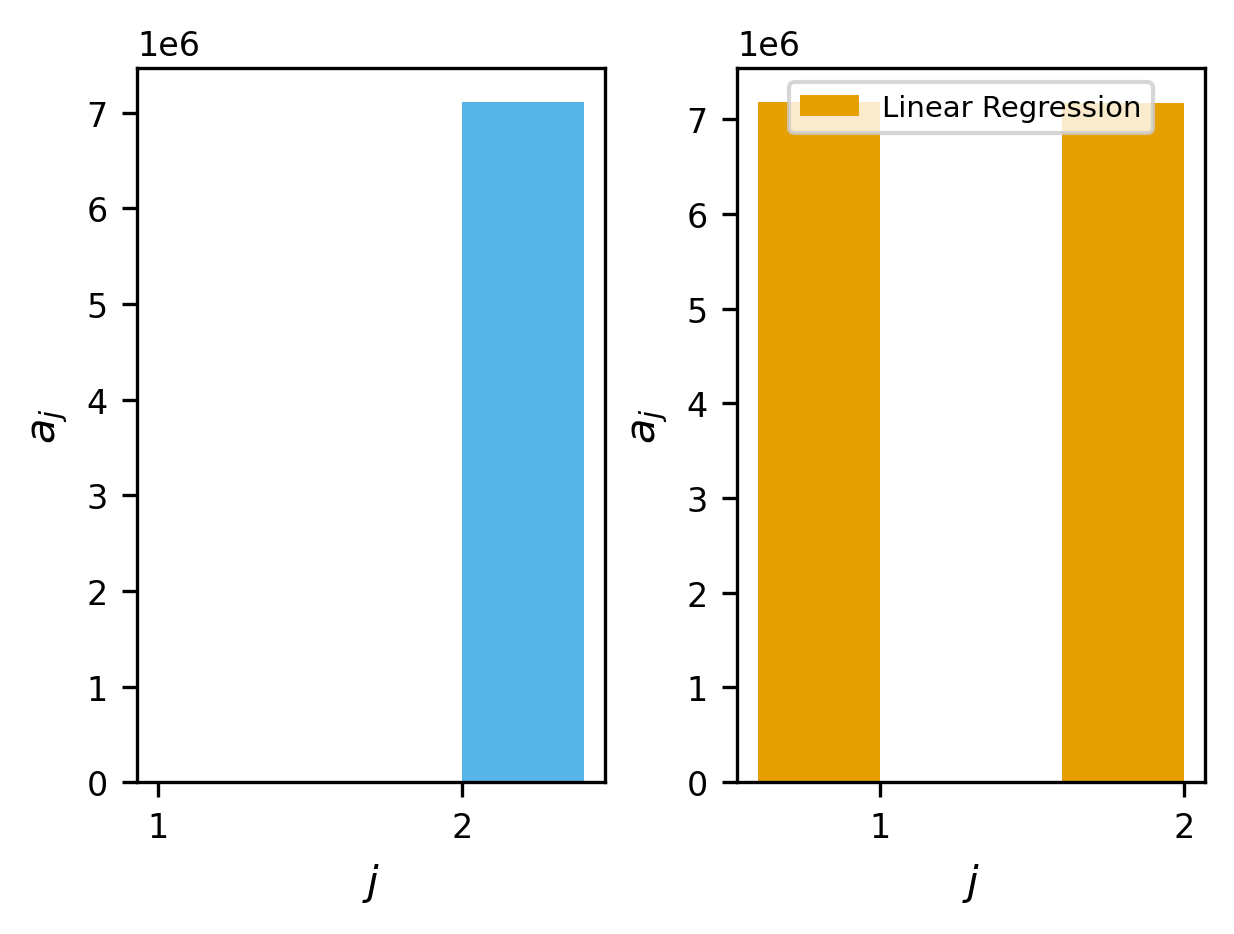

In [19]:
#########################################################################
#
# Plot the results on top of eachother
#
#########################################################################

c1=ok['blue']
c2=ok['orange']
c3=ok['green']
c4=ok['purple']

# Run a quick sweep to get smaller plots in an acceptable format
get_wide_plot(plt.rcParams)

plt.figure(layout='constrained')
plt.subplot(121)
plt.plot(x, best_fit ** 2 , label='Simple Fitting', color=c1)
plt.plot(x, np.abs(linear_optimized_fields) ** 2, label='Linear Regression', color=c2)
plt.plot(x, np.abs(target_barrier) ** 2, linestyle=(0, (5, 1)), label='Target Potential', color=c3)
plt.plot(x, np.abs(Phi(x, max(k), amplitude=ampl, phase=0)) ** 2, label='Shortest $\lambda$ Component', color=c4, zorder=0)
plt.xlabel('$x$ (arb. u.)')
plt.ylabel('$V_{\\rm control}$ (arb. u.)')
plt.xlim(x[0], x[-1])
plt.ylim(-0.025, 1.5*ampl**2)
plt.legend(loc='upper center')

plt.subplot(122)
plt.bar(np.arange(1, n+1, 1)+0.2, np.abs([opt_vals[_] for _ in np.arange(1, len(opt_vals-1), 2)]), width=0.4, color=c1, label='Simple Fitting')
plt.bar(np.arange(1, n+1, 1)-0.2, np.abs(single_func_amps), width=0.4, color=c2, label='Linear Regression')
plt.xticks(np.arange(1, n+1, 1))
plt.ticklabel_format(axis='y', style='sci', scilimits=[-5, 3])
plt.xlabel('$j$')
plt.ylabel('$a_j$')
plt.legend(loc='upper center')

#plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_combined.pdf')

plt.figure(layout='constrained')
plt.subplot(121)
plt.bar(np.arange(1, n+1, 1)+0.2, np.abs([opt_vals[_] for _ in np.arange(1, len(opt_vals-1), 2)]), width=0.4, color=c1, label='Simple Fitting')
plt.xticks(np.arange(1, n+1, 1))
plt.ticklabel_format(axis='y', style='sci', scilimits=[-5, 3])
plt.xlabel('$j$')
plt.ylabel('$a_j$')
plt.subplot(122)
plt.bar(np.arange(1, n+1, 1)-0.2, np.abs(single_func_amps), width=0.4, color=c2, label='Linear Regression')
plt.xticks(np.arange(1, n+1, 1))
plt.ticklabel_format(axis='y', style='sci', scilimits=[-5, 3])
plt.xlabel('$j$')
plt.ylabel('$a_j$')
plt.legend(loc='upper center')

# Now that the wide plot is done, return to standardized plotting
ok = utlt.standardize_plots(plt.rcParams)


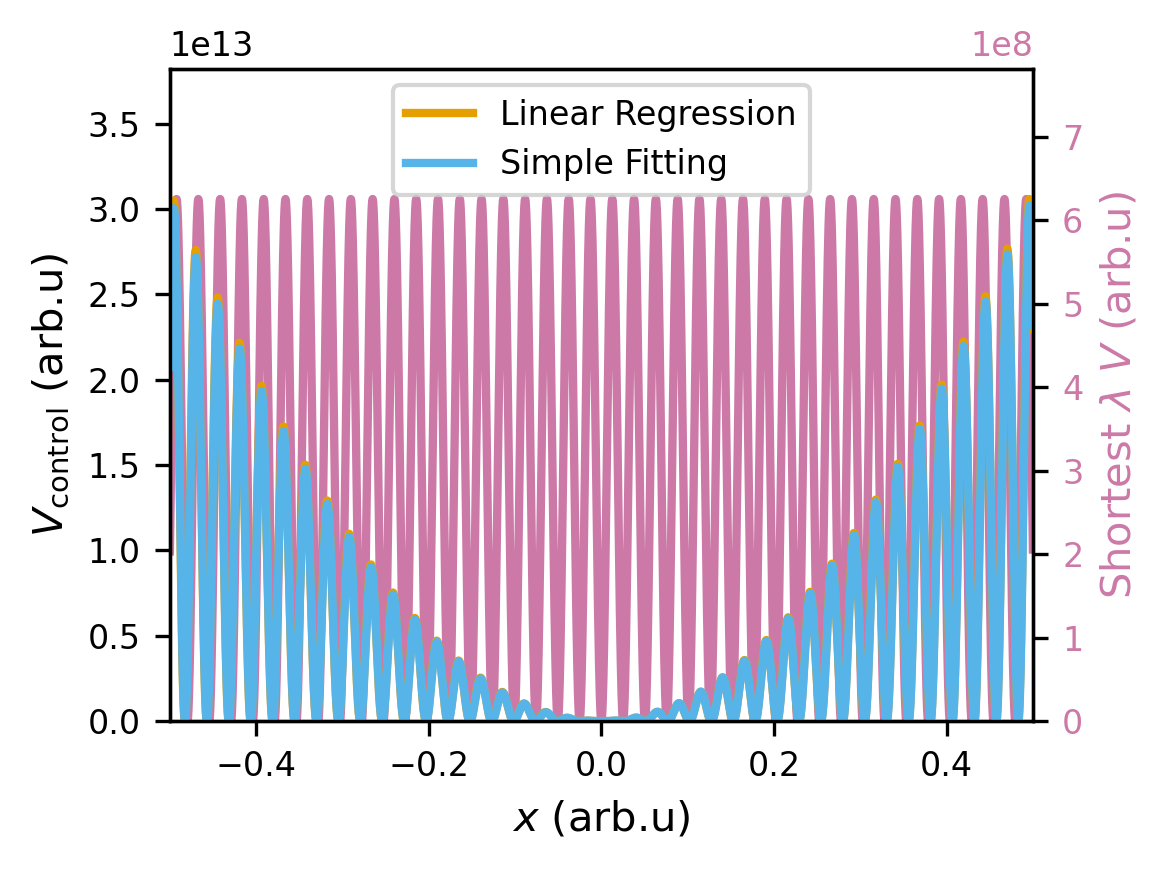

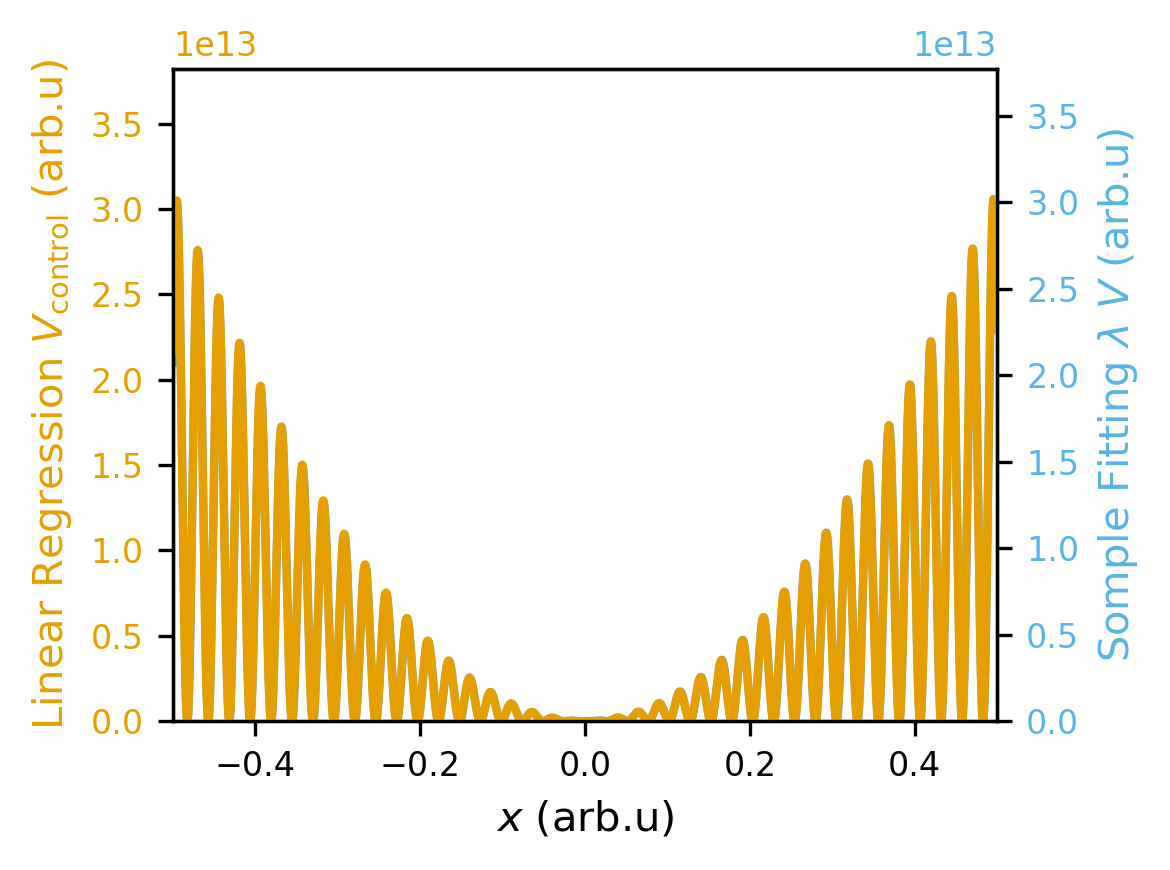

In [20]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(x_full, np.abs(lo_fields_zoom) ** 2, label='Linear Regression', color=c2)
ax1.plot(x_full, np.abs(best_fit_zoom) ** 2, label='Simple Fitting', color=c1)

ax2=ax1.twinx()
ax2.plot(x_full, np.abs(Phi(x_full, max(k), amplitude=ampl)) ** 2, label='Shortest $\lambda$ component $V$', color=c4)

#ax1.tick_params('y', labelcolor=c1)
ax1.set_ylim(0, 1.25 * max(np.abs(lo_fields_zoom) ** 2))
ax2.tick_params('y', labelcolor=c4)
ax2.set_ylim(0, 1.25 * ampl ** 2)
ax1.legend(loc='upper center')
ax1.set_xlabel('$x$ (arb.u)')
ax1.set_ylabel('$V_{\\rm control}$ (arb.u)')
ax2.set_ylabel('Shortest $\lambda$ $V$ (arb.u)', color=c4)
ax1.set_xlim(-x_lim, x_lim)

ax1.set_zorder(3)
ax1.patch.set_visible(False)

plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Results_combinedZoomed.pdf')
#plt.savefig('./Plots/Presentation/Results_linearZoomed.pdf')
plt.show()

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(x_full, np.abs(lo_fields_zoom) ** 2, label='Linear Regression', color=c2)

ax2=ax1.twinx()
ax2.plot(x_full, np.abs(best_fit_zoom) ** 2, label='Simple Fitting', color=c1)

#ax1.tick_params('y', labelcolor=c1)
ax1.set_ylim(0, 1.25 * max(np.abs(lo_fields_zoom) ** 2))
ax1.tick_params('y', labelcolor=c2)
ax2.tick_params('y', labelcolor=c1)
ax2.set_ylim(0, 1.25 * max(np.abs(best_fit_zoom) ** 2))
ax1.set_xlabel('$x$ (arb.u)')
ax1.set_ylabel('Linear Regression $V_{\\rm control}$ (arb.u)', color=c2)
ax2.set_ylabel('Somple Fitting $\lambda$ $V$ (arb.u)', color=c1)
ax1.set_xlim(-x_lim, x_lim)

ax1.set_zorder(3)
ax1.patch.set_visible(False)
plt.savefig(f'{file_path}/{file_name}_Results_combinedZoomed_onlyFits.pdf')

plt.tight_layout()
plt.show()

## Solving the eigenvalue equation begins here


In [21]:
#########################################################################
#
# Alternate option, generating best fields by solving eigenvalue problem
#
#########################################################################
# Redeclare fields here if the fitting was skipped
fields = np.array([
    Phi(x, i, j) for i, j in product(freqs, [0, np.pi/2])
]).T

fields_zoomed = np.array([
    Phi(x_full, i, j) for i, j in product(freqs, [0, np.pi/2])
]).T
# create the overlap matrix
S = fields.T @ fields
# Solve the eigenvalue problem
vals, vecs = eigh(S)

eig_fields = [fields @ vecs[:, _] for _ in range(len(vecs[:]))]
eig_fields_zoomout = [fields_zoomed @ vecs[:, _] for _ in range(len(vecs[:]))]


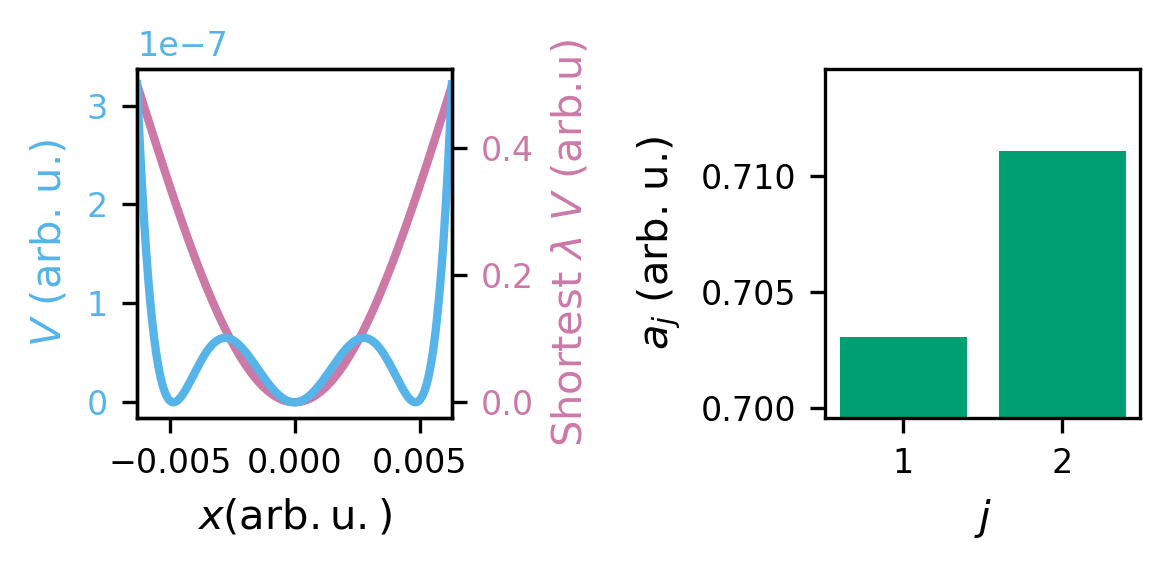

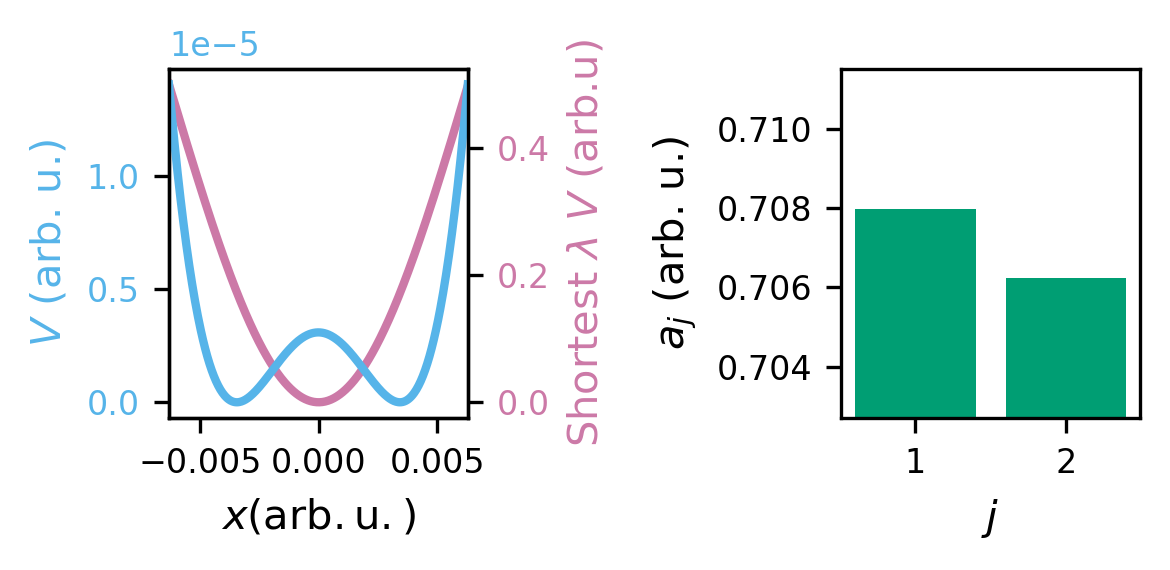

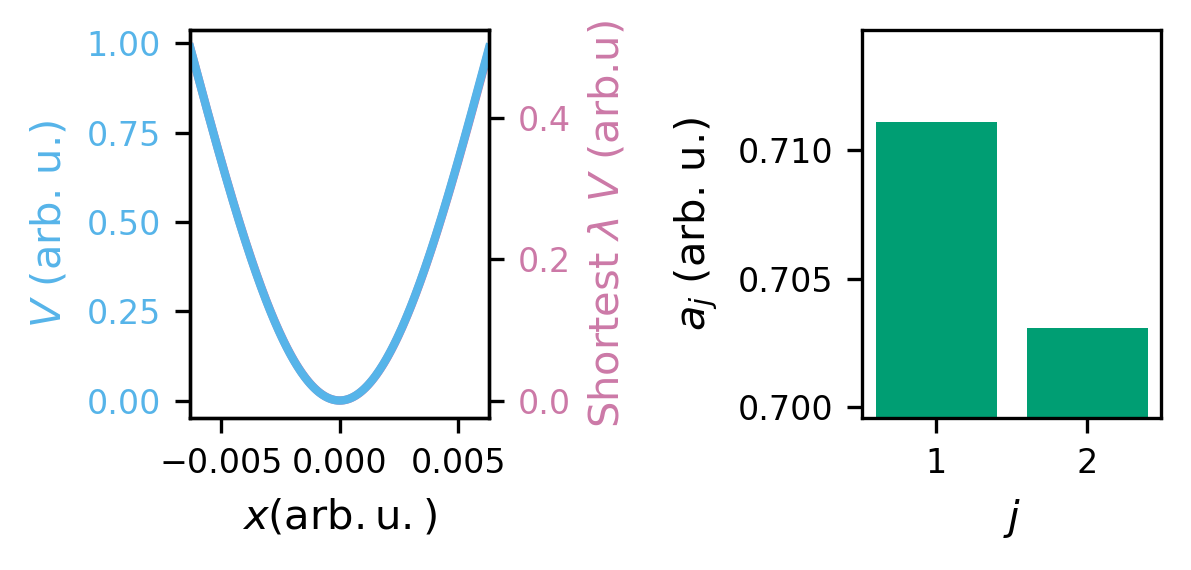

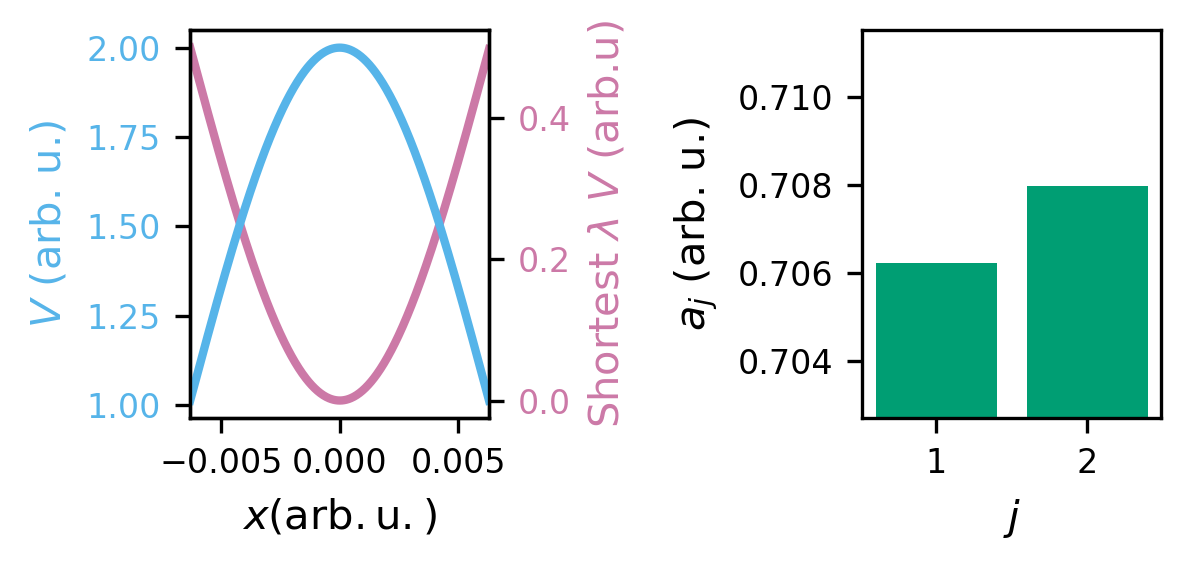

In [22]:
k_max = max(k)
largest_freq_pulse = Phi(x, max(k))
largest_freq_pulsez = Phi(x_full, max(k))


color1 = ok['blue']
color2 = ok['purple']
color3 = ok['green']
color4 = ok['amber']

get_wide_plot(plt.rcParams)

for _ in range(n*2):
    #fig, (ax1, ax1_, ax1__) = plt.subplots(1, 3, figsize=(8, 3), dpi=300)
    fig, (ax1, ax1__) = plt.subplots(1, 2, figsize=(4,2))
    eig_vector=vecs[:, _]
    combined_eig_vecs = [Phi_combine_amps(eig_vector[_+1],eig_vector[_]) for _ in np.arange(0, len(eig_vector), 2)]
    combined_eig_phases = [Phi_combine_phases(eig_vector[_+1],eig_vector[_]) for _ in np.arange(0, len(eig_vector), 2)]
    combined_eig_fields = [Phi(x, freqs[_], phase=combined_eig_phases[_], amplitude=combined_eig_vecs[_]) for _ in range(n)]
    
    ax1.set_ylabel('$V$ (arb. u.)', color=color1)
    ax1.plot(x, np.sum(combined_eig_fields, axis=0) ** 2, color=color1)
    #ax1.plot(x, np.abs(eig_fields[_]) ** 2, color=color4, linestyle='--')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xlim(x[0], x[-1])

    ax1.set_xlabel('$x {\\rm (arb. u.)}$')
    
    ax2 = ax1.twinx() 
    
    ax2.set_ylabel('Shortest $\lambda$ $V$ (arb.u)', color=color2)
    ax2.plot(x, largest_freq_pulse ** 2, color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)    
    ax1.set_zorder(1)
    ax1.patch.set_visible(False)

    # plot zoom out view
    
    """ax1 = ax1_
    
    ax1.set_ylabel('$V$ (arb.u)', color=color1)
    ax1.plot(x_full, eig_fields_zoomout[_] ** 2, color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel('$x$ (arb.u)')

    ax2 = ax1.twinx() 

    ax2.plot(x_full, largest_freq_pulsez ** 2, color=color2)
    ax2.set_ylabel('Shortest $\lambda$ $V$ (arb. u.)', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax1.set_zorder(1)
    ax1.patch.set_visible(False)"""
    
    # plot pulses
    ax1 = ax1__
    
    ax1.bar(np.arange(1, n+1, 1), combined_eig_vecs, color=color3)
    #bar_width=0.75*(freqs[1]-freqs[0])
    #ax1.bar(freqs, combined_eig_vecs, width=bar_width, color=color4)
    #ax1.set_xticks(freqs)
    ax1.set_xticks(np.arange(1, n+1, 1))
    ax1.set_ylim(0.995 * min(combined_eig_vecs), 1.005 * max(combined_eig_vecs))
    ax1.set_xlabel('$j$')
    ax1.set_ylabel('$a_{j}$ (arb. u.)')
    
    fig.tight_layout()
    plt.savefig(f'{file_path}/{file_name}_aBa_EigenvectorSolution{_}.pdf')

plt.show()

ok=utlt.standardize_plots(plt.rcParams)

In [55]:
np.shape(eig_fields)


(4, 414)

In [52]:
#########################################################################
#
# After visually assessing optimal field, declare it here 
#
#########################################################################

best_plot = 1
eig_winner = eig_fields[best_plot]
winner_zoom = eig_fields_zoomout[best_plot]
winner_amps = vecs[:, best_plot]
winner_combined_amps = np.array([Phi_combine_amps(vecs[_+1, best_plot], vecs[_, best_plot]) for _ in np.arange(0, len(eig_vector), 2)])
winner_combined_phases = np.array([Phi_combine_phases(vecs[_+1, best_plot], vecs[_, best_plot]) for _ in np.arange(0, len(eig_vector), 2)])


# visual assesment modifier
vam = 3e8

scalings = np.array([f2V_scaling(_) for _ in λ_control])
field_scalings = np.abs(scalings[:, 0])
field_orders = scalings[:,1]
b_j_2 = gpe.convert_energy((winner_combined_amps) ** 2, 0, 'J')
b2_order = np.array([order(_) for _ in b_j_2])
b_j = np.array([np.sqrt( _ * 10 ** (-1*order(_))) for _ in b_j_2])
a_j_2 = 2 * vam * b_j ** 2 * (field_scalings ** -1) * 10 ** (b2_order - field_orders)
a_j = np.sqrt(a_j_2)
print(f'The field amplitude^2 in "Joules" are {a_j_2}')
print(f'The potential energy prefactors are {field_scalings} with orders of {field_orders}')



The field amplitude^2 in "Joules" are [15565.13383479   372.25584394]
The potential energy prefactors are [0.64013563 0.26633333] with orders of [-29. -27.]


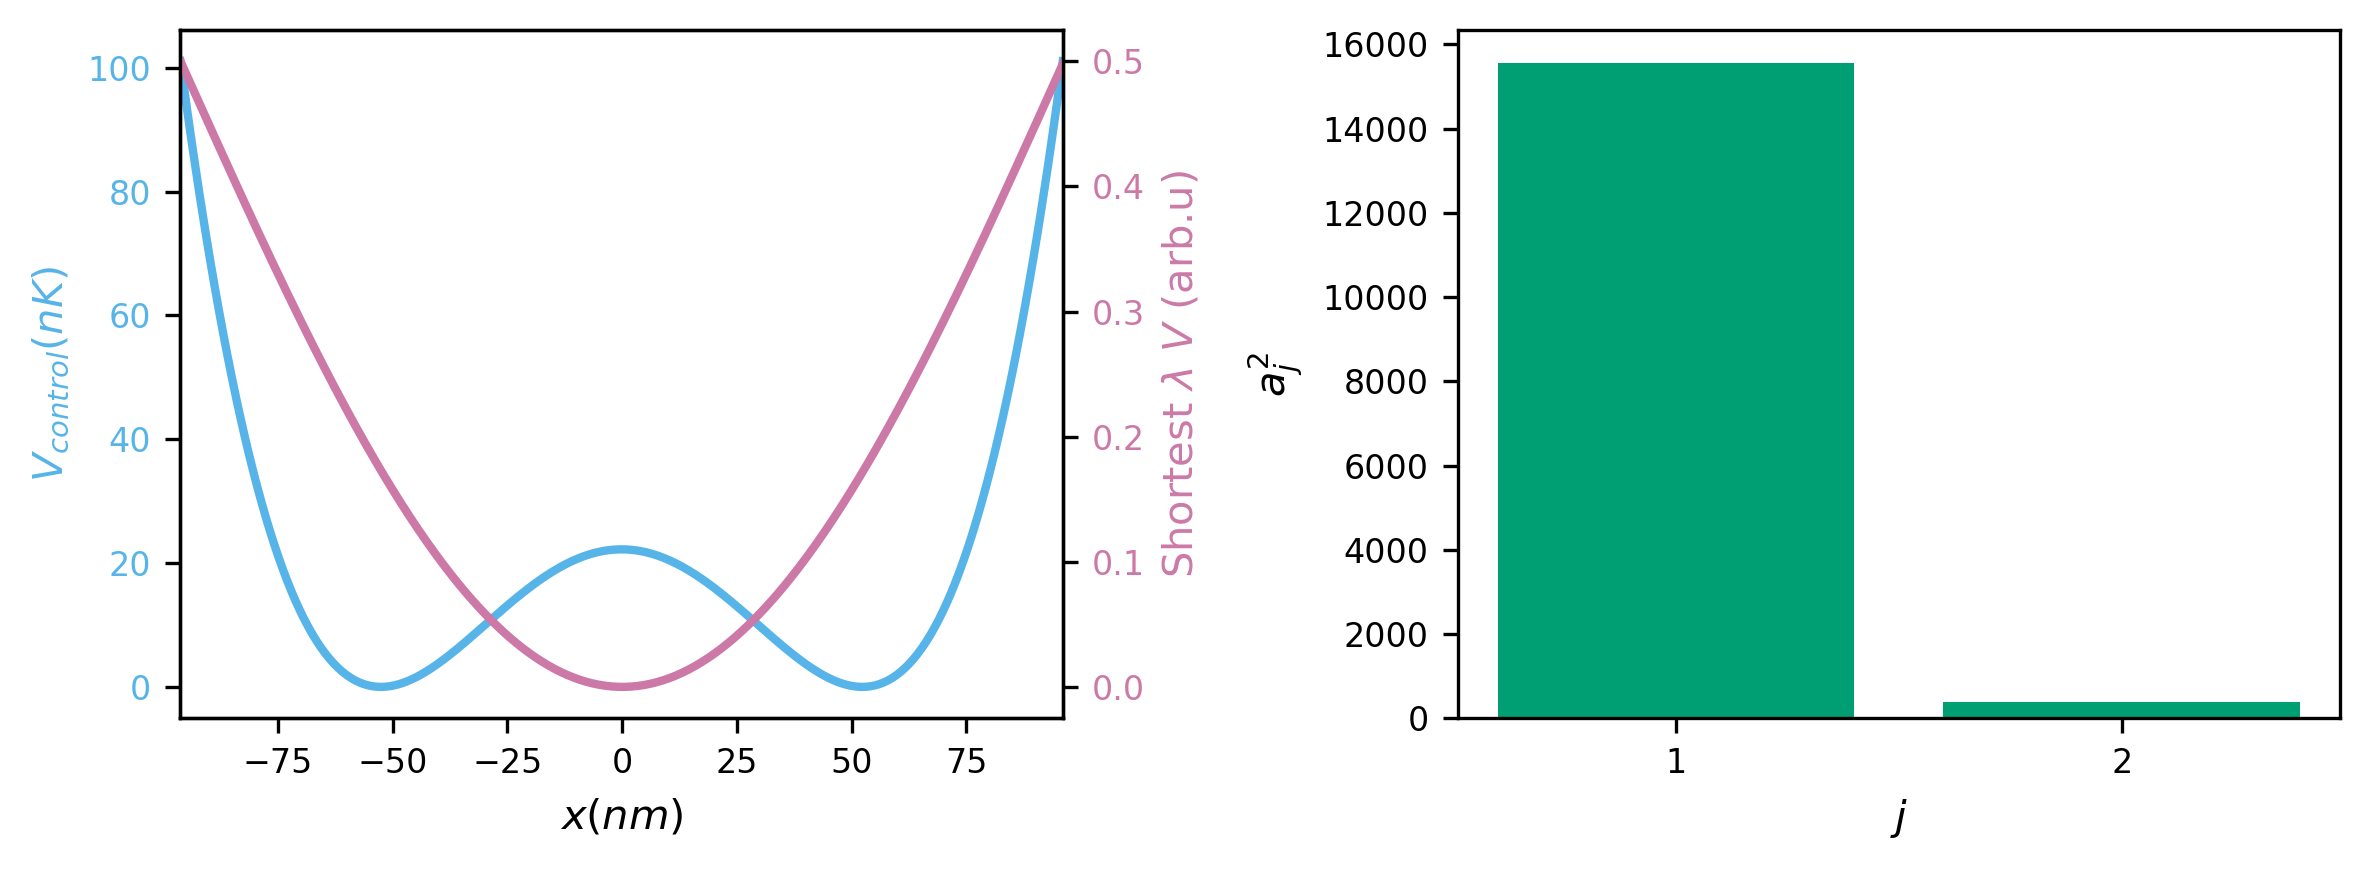

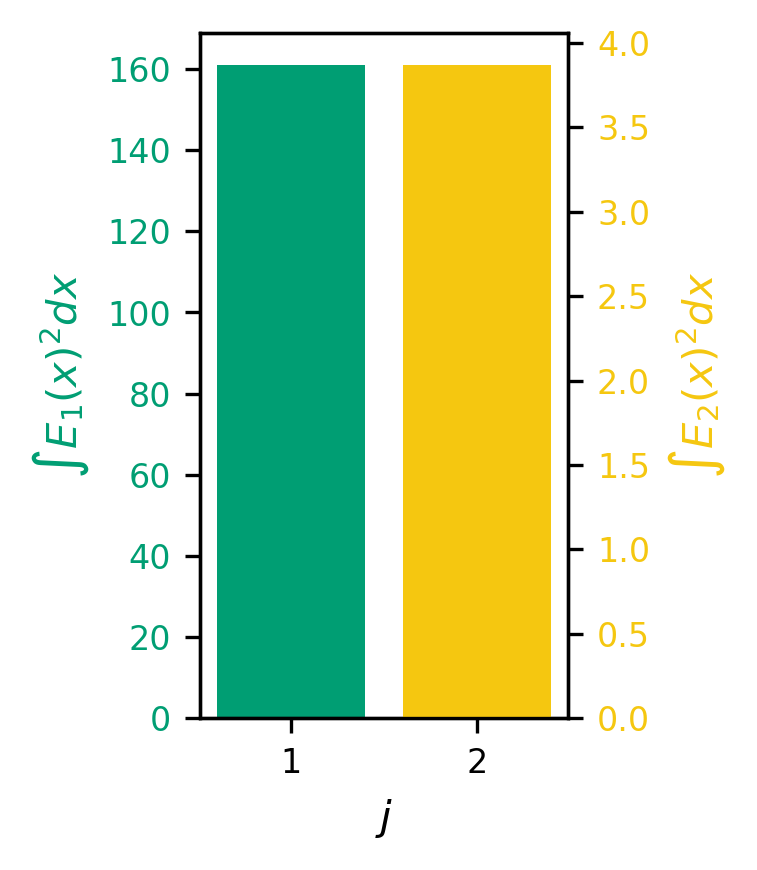

In [53]:
adjusted_eig_winner = np.sqrt(vam) * eig_winner
adjusted_eig_zoom = np.sqrt(vam) * winner_zoom
adj_winner_amps = np.sqrt(vam) * winner_amps

adj_indv_fields = np.array([Phi(x, freqs[_], phase=winner_combined_phases[_], amplitude=a_j[_]) for _ in range(n)])
intensities = np.sum((adj_indv_fields ** 2) * dx, axis=1)

fig=plt.figure(figsize=(8,3))
ax1=fig.add_subplot(121)
ax1.plot(x_units, gpe.convert_energy(adjusted_eig_winner ** 2, -9), color=color1)
ax1.set_xlabel('$x (nm)$')
ax1.set_xlim(x_units[0], x_units[-1])
ax1.set_ylabel('$V_{control} (nK)$', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
ax2.plot(x_units, largest_freq_pulse ** 2, color=color2)
ax2.set_ylabel('Shortest $\lambda$ $V$ (arb.u)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

ax3 = fig.add_subplot(122)
ax3.bar(np.arange(1, n+1, 1), 
        a_j_2, color=ok['green'])
ax3.set_xticks(np.arange(1, n+1, 1))
ax3.set_xlabel('$j$')
#ax3.set_ylabel('$\\frac{\\alpha(\\omega)}{2} a_{j}^{2}$ (MJ)')
ax3.set_ylabel('$a_{j}^{2}$')
plt.tight_layout()
#plt.savefig(f'{file_path}/{file_name}_EigenvectorSolution_Scaled.pdf')
plt.show()   

fig=plt.figure()
ax1=fig.add_subplot(121)
ax1.bar([1, 2], [intensities[0], 0], color=color3)
ax1.set_xlabel('$j$')
ax2 = ax1.twinx()
ax2.bar([1, 2], [0, intensities[1]], color=color4)
ax1.set_ylabel('$\int E_{1}(x)^2 dx$', color=color3)
ax1.tick_params(axis='y', labelcolor=color3)
ax2.set_ylabel('$\int E_{2}(x)^2 dx$', color=color4)
ax2.tick_params(axis='y', labelcolor=color4)
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_EigenvectorSolution_Intensities.pdf')
plt.show()

## Below is the BEC section. Please declare the field you wish to use.

In [25]:
########################################################################################################################
# The field goes here
########################################################################################################################

pre_cooling = True
tags_opts = ['BestFit', 'SKLearnLinReg', f'EigenSolution_{best_plot}']
#field_opts = [[best_fit, best_fit_zoom], [linear_optimized_fields, lo_fields_zoom], [adjusted_eig_winner, adjusted_eig_zoom]]

op = 2

#test_field_so_window, test_field_full = field_opts[op]
test_field_so_window, test_field_full = [adjusted_eig_winner, adjusted_eig_zoom]
test_field_tag = tags_opts[op]

# Coordinates are declared as z for ease of reading
# Coordinate x is still used when viewing SO window
dz = dx
z = x_full
z_micro = gpe.convert_x(x_full, -6)
z_nano = gpe.convert_x(x_full, -9)
λ_min = min(λ_control)
T = 10
times = np.linspace(0, T, 500)

# Potentials as "functions"
VV = UnivariateSpline(z, (np.abs(test_field_full) ** 2), s=0)
vv = UnivariateSpline(x, (np.abs(test_field_so_window) ** 2), s=0)


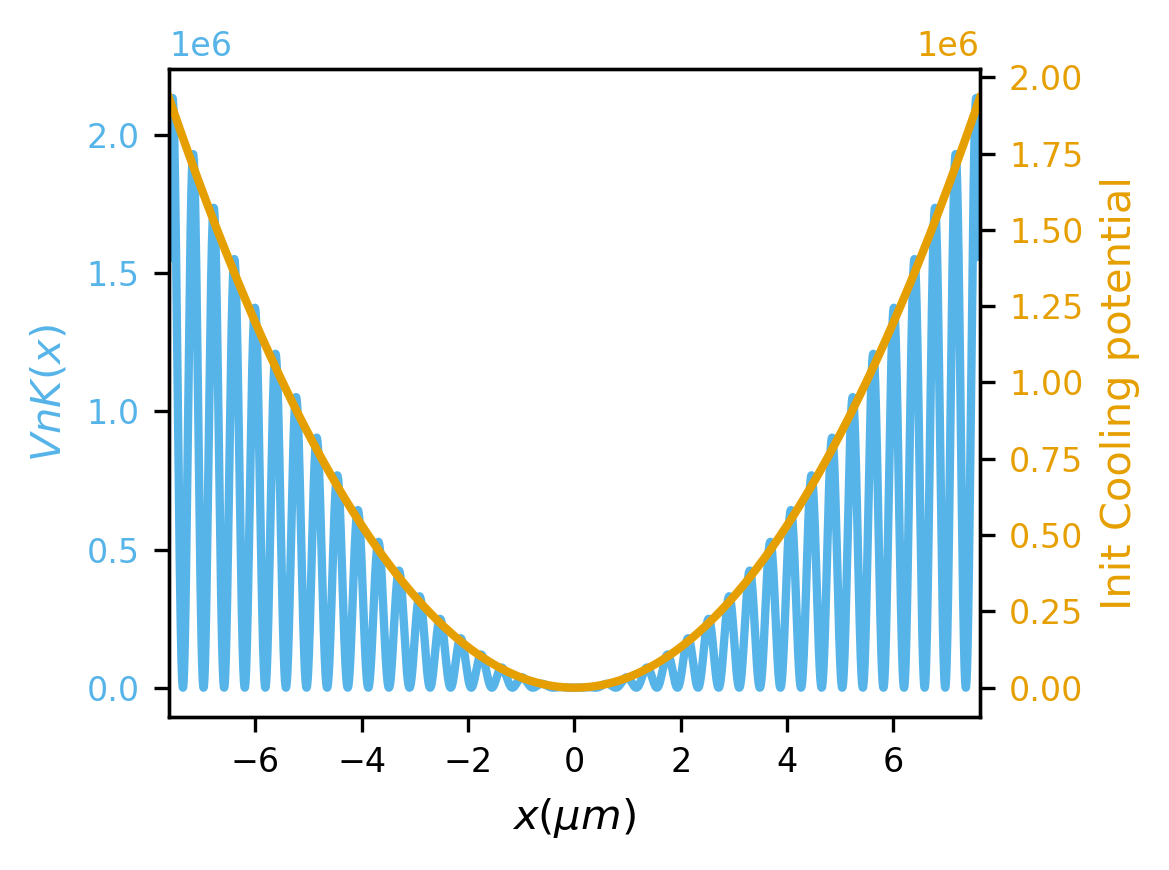

In [26]:
########################################################################################################################
# Get the BEC
########################################################################################################################


@njit
def diff_k(p):
    """
    the derivative of the kinetic energy for Ehrenfest theorem evaluation
    """
    return p


@njit(parallel=True)
def ke(p):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2
    
suggestion_slope = 1 # 1 / (2 * np.pi)
suggestion_sin = Phi(z, np.pi / (2 * x_lim), amplitude=2*ampl) ** 2

dimless_Tc = gpe.dimless_energy(T_c, -9)


@njit(parallel=True)
def first_pass_cooling(x):
    """
    Non-relativistic kinetic energy
    """
    return ((max(test_field_full) * x) / x_lim) ** 2

def fwhm(density, grid):
    index = np.where(density >= 0.5*density.max())[0]
    return grid[index[-1]] - grid[index[0]], [grid[index[0]], grid[index[-1]]]

first_pass_params = dict(
    x_amplitude=x_lim,
    x_grid_dim=x_res,
    N=N,
    k=ke,
    initial_trap=first_pass_cooling,
    times=times,
    diff_k=diff_k,
    get_mu=True,
)

sys_params = dict(
    x_amplitude=x_lim,
    x_grid_dim=x_res,
    N=N,
    k=ke,
    initial_trap=VV,
    times=times,
    diff_k=diff_k,
    get_mu=True,
)

c1 = ok['blue']
c2 = ok['orange']

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z_micro, gpe.convert_energy(sys_params['initial_trap'](z), -9), label='SO Potential', color=c1)
ax1.set_xlabel('$x (μm)$')
ax1.set_xlim(z_micro[0], z_micro[-1])

if pre_cooling:
    ax2 = ax1.twinx()
    ax2.plot(z_micro, gpe.convert_energy(first_pass_cooling(z), -9), label='Initial Cooling Potential', color=c2)
    ax2.set_ylabel('Init Cooling potential', color=c2)
    ax2.tick_params(axis='y', labelcolor=c2)

ax1.set_ylabel('$V nK(x)$', color=c1)
ax1.tick_params(axis='y', labelcolor=c1)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-1e-4, 1e-4))
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_CoolingPotential_{test_field_tag}.pdf')
plt.show()



In [27]:
if pre_cooling:
    init_state, E, mu = imag_time_gpe1D(
        v=first_pass_params['initial_trap'],
        g=g,
        dt=1e-6,
        epsilon=1e-8,
        **sys_params
    )
    
    init_state, E, mu = imag_time_gpe1D(
        v=first_pass_params['initial_trap'],
        g=g,
        init_wavefunction=init_state,
        dt=1e-8,
        epsilon=1e-10,
        **sys_params
    )
    
    print(f'Initial BEC Energy: {gpe.convert_energy(E, -9)} nK')
    print(f'This compared to the Critical Temperature:  {T_c} nK')


Starting imaginary time propagation
current ground state energy = 4.3599e+05


Final ground state energy = 4.5553e+04
Final Chemical potential = 7.2115e+04

Starting imaginary time propagation
current ground state energy = 4.5553e+04
current ground state energy = 4.5551e+04


Final ground state energy = 4.5551e+04
Final Chemical potential = 7.2204e+04
Initial BEC Energy: 1093.0491890071041 nK
This compared to the Critical Temperature:  111185.92893691169 nK


In [28]:
if pre_cooling:
    init_state, E, mu = imag_time_gpe1D(
        init_wavefunction=init_state,
        v=sys_params['initial_trap'],
        g=g,
        dt=1e-6,
        epsilon=1e-8,
        **sys_params
    )

else:
    init_state, E, mu = imag_time_gpe1D(
        v=sys_params['initial_trap'],
        g=g,
        dt=1e-6,
        epsilon=1e-8,
        **sys_params
    )

init_state, E, mu = imag_time_gpe1D(
    v=sys_params['initial_trap'],
    g=g,
    init_wavefunction=init_state,
    dt=1e-8,
    epsilon=1e-10,
    **sys_params
)

print(f'Initial BEC Energy: {gpe.convert_energy(E, -9)} nK')
print(f'This compared to the Critical Temperature:  {T_c} nK')

assert gpe.convert_energy(E, -9) < T_c, "This is not a BEC!, T > T_c"



Starting imaginary time propagation
current ground state energy = 4.2710e+04


Final ground state energy = 3.8356e+04
Final Chemical potential = 5.6444e+04

Starting imaginary time propagation
current ground state energy = 3.8356e+04
current ground state energy = 3.8353e+04
current ground state energy = 3.8353e+04


Final ground state energy = 3.8353e+04
Final Chemical potential = 5.6583e+04
Initial BEC Energy: 920.3367675503486 nK
This compared to the Critical Temperature:  111185.92893691169 nK


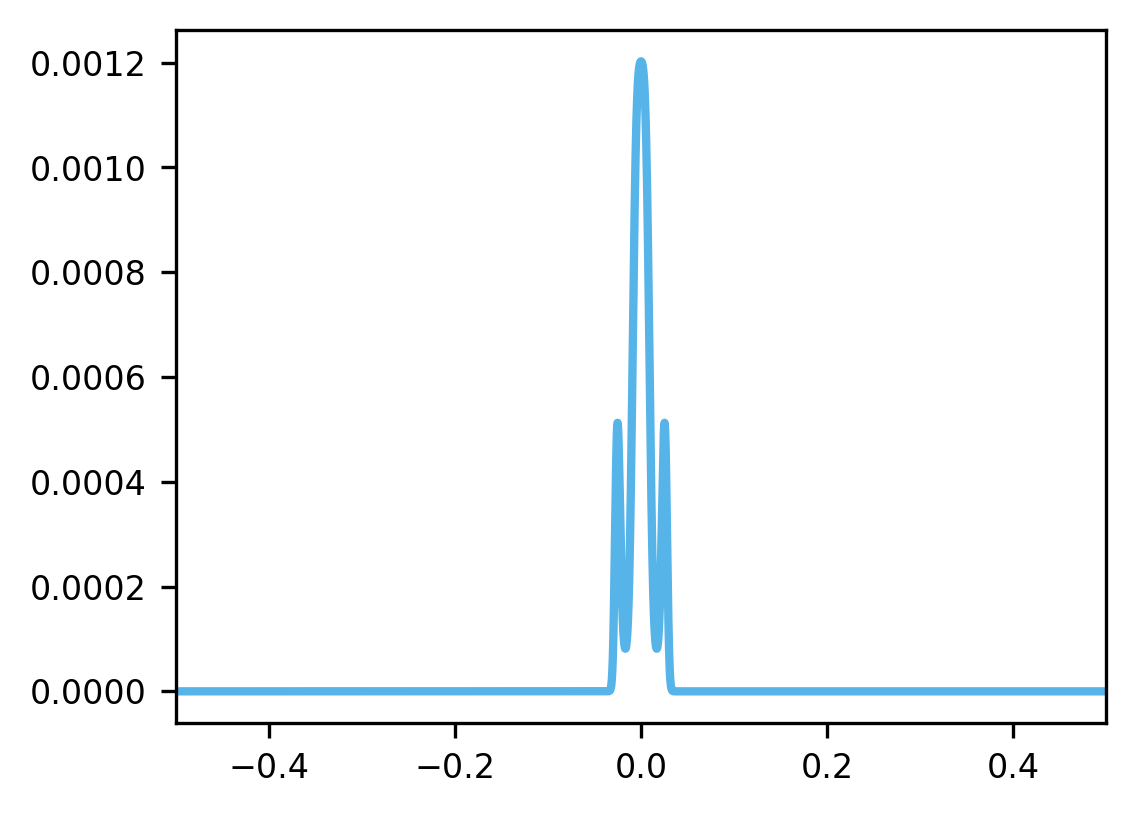

Sanity Check, the density is: 1.0000000000000004


In [29]:
density = np.abs(init_state) ** 2 * dz
plt.plot(z, density)
plt.xlim(z[0], z[-1])
plt.show()

print(f'Sanity Check, the density is: {np.sum(density)}')

In [30]:
# Perform Full Width, Half Max Calculation after seeing density
width, x_width = fwhm(density, z)

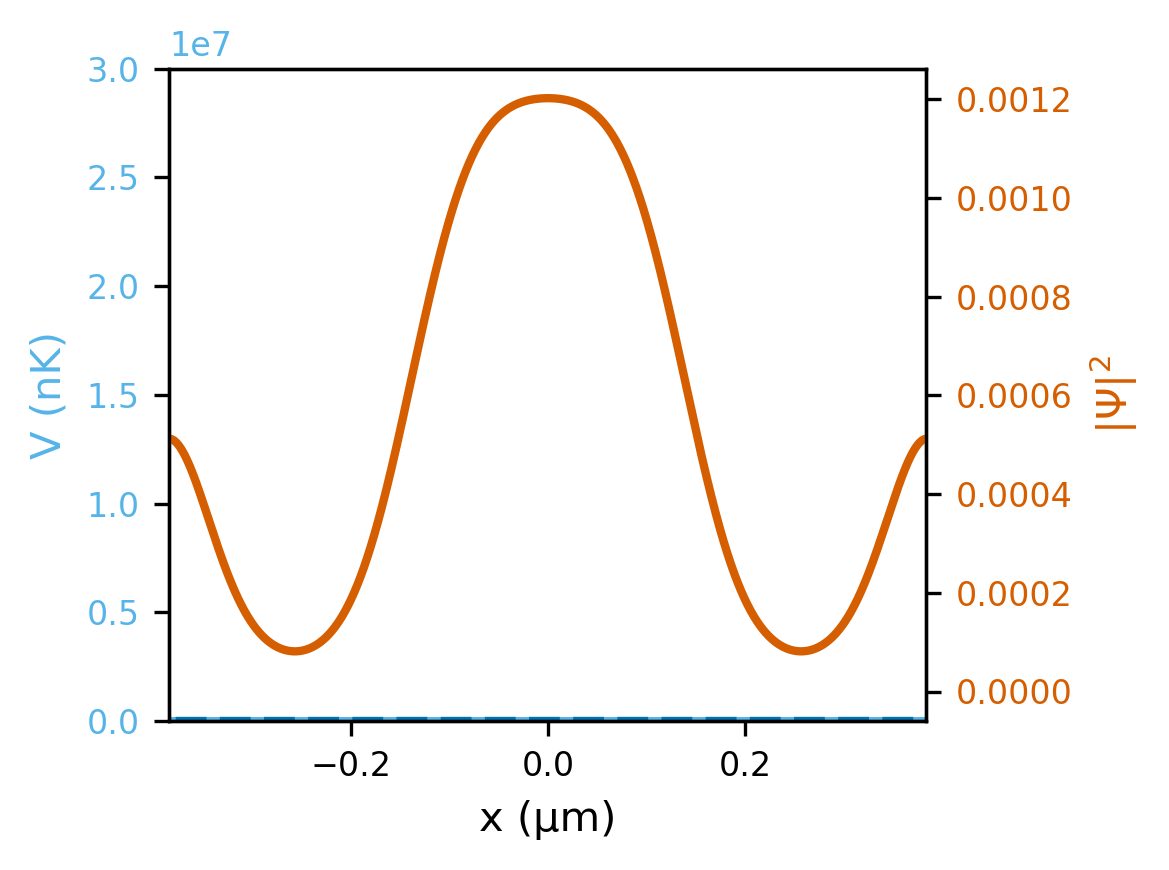

In [31]:
fig=plt.figure()
phys_potential = gpe.convert_energy(sys_params['initial_trap'](z), -9)
ax1=fig.add_subplot(111)
ax1.plot(z_micro, phys_potential, color=ok['blue'])
ax1.hlines(gpe.convert_energy(E, -9), gpe.convert_x(z[0], -6), gpe.convert_x(z[-1], -6), linestyle='--', color=ok['navy'])
ax1.set_xlabel('x (μm)')
ax1.set_xlim(gpe.convert_x(4 * x[0], -6), gpe.convert_x(4 * x[-1], -6))
ax2=ax1.twinx()
ax2.plot(z_micro, density, color=ok['red'])
#ax2.plot(gpe.convert_x(x, -6), UnivariateSpline(gpe.convert_x(z, -6), density, s=0)(gpe.convert_x(x, -6)), color=ok['orange'])
ax1.set_ylabel('V (nK)', color=ok['blue'])
ax1.set_ylim(0, gpe.convert_energy(2*ampl**2, -9))
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylabel('$|\\Psi|^2$', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ZoomedInitState_inPotential_{test_field_tag}.pdf')
plt.show()


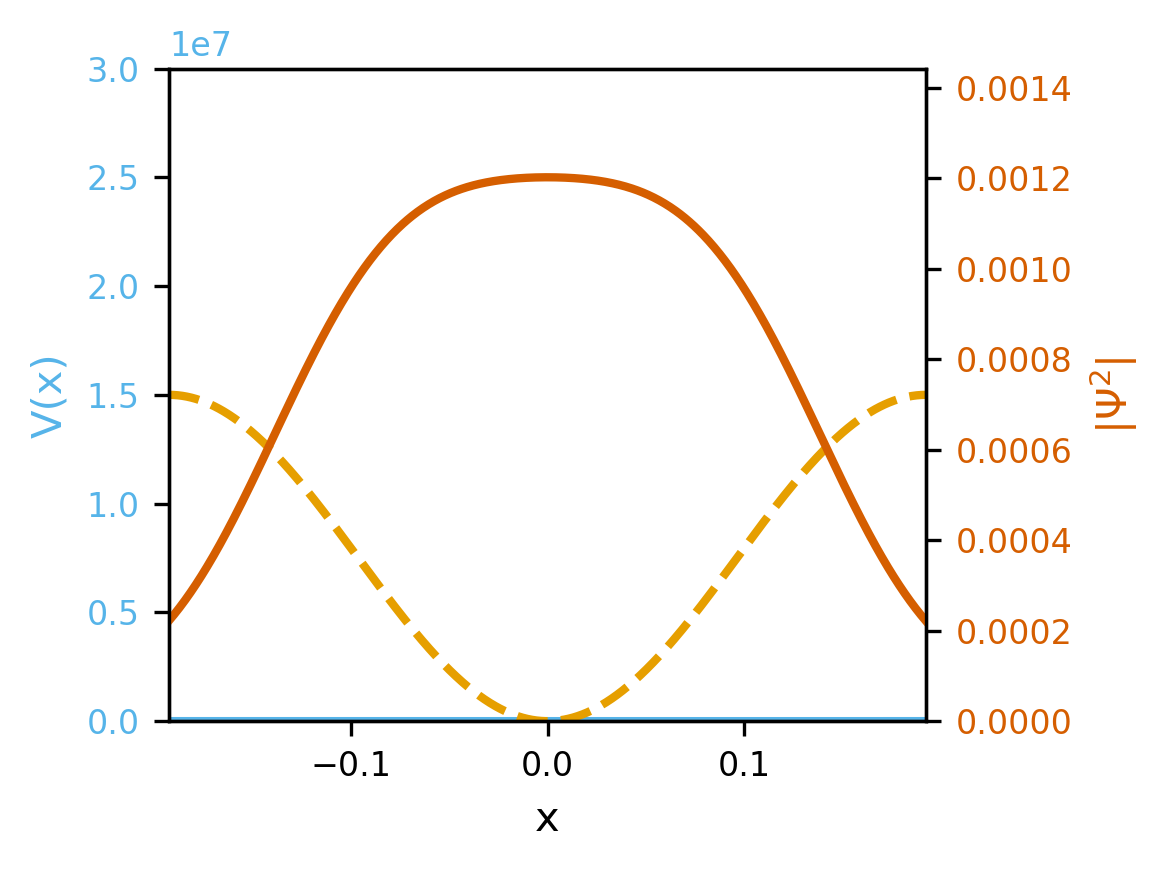

In [32]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(gpe.convert_x(z, -6), gpe.convert_energy(sys_params['initial_trap'](z), -9), color=ok['blue'])
ax1.plot(gpe.convert_x(z, -6), gpe.convert_energy(np.abs(Phi(z, max(k), amplitude=ampl, phase=0)) ** 2, -9), '--', color=ok['orange'])
ax1.set_xlabel('x')
ax1.set_xlim(gpe.convert_x(-2*np.pi/k_target, -6), gpe.convert_x(2*np.pi/k_target, -6))
ax2=ax1.twinx()
ax2.plot(gpe.convert_x(z, -6), density, color=ok['red'])
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V(x)', color=ok['blue'])
ax1.set_ylim(0, gpe.convert_energy(2*ampl**2, -9))
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylim(0, 1.2*density.max())
ax2.set_ylabel('|$\\Psi^2$|', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ZoomedInitState_inPotential_overlapped_{test_field_tag}.pdf')
#plt.savefig(f'{file_path}/{file_name}_ZoomedInitState_inPotential_overlapped.png')
plt.show()

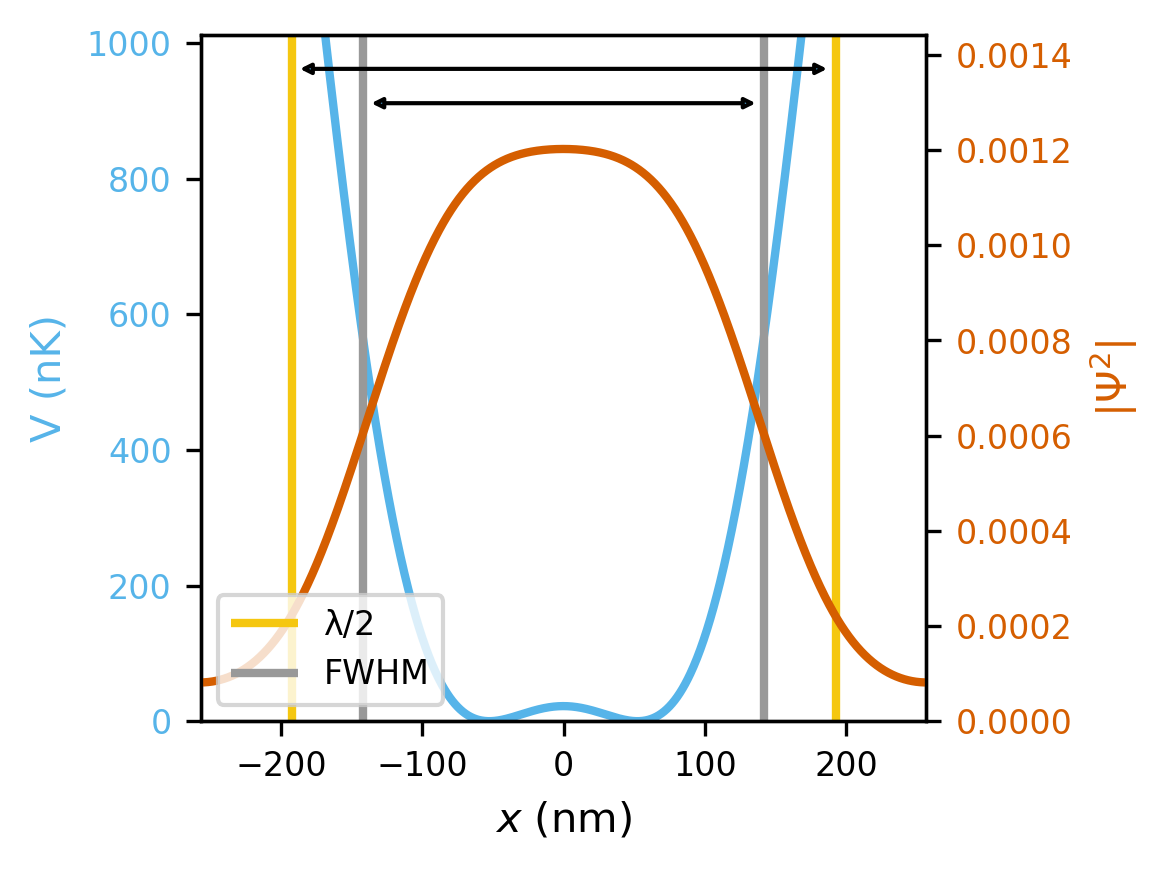

In [33]:
plot_max = 1.1 * gpe.convert_energy(E, -9)

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z_nano, gpe.convert_energy(sys_params['initial_trap'](z), -9), color=ok['blue'])
#ax1.plot(z, np.abs(Phi(z, max(k), amplitude = ampl, phase=0)) ** 2, '--', color=ok['orange'])

ax1.vlines([-λ_min/4, λ_min/4], 0, plot_max, color=ok['amber'], label='λ/2')
ax1.vlines(gpe.convert_x(x_width, -9), 0, plot_max, color=ok['grey'], label='FWHM')
#ax1.vlines([-λ/4, λ/4], 0, plot_max, color=ok['grey'], label='Target λ')
#ax1.vlines(peak_locations, 0, plot_max, color=ok['grey'], label='Density Peak spacing')
#ax1.hlines(gpe.convert_energy(E, -9), gpe.convert_x(z[0], -6), gpe.convert_x(z[-1], -6), linestyle='--', color=ok['navy'], label='BEC Energy')
ax1.add_patch(patches.FancyArrowPatch(
    (-λ_min/4, 0.95*plot_max), 
     (λ_min/4, 0.95*plot_max), 
      arrowstyle='<|-|>', mutation_scale=5)).set_zorder(3)
ax1.add_patch(patches.FancyArrowPatch(
    (gpe.convert_x(x_width[0], -9), 0.9*plot_max), 
    (gpe.convert_x(x_width[1], -9), 0.9*plot_max), 
    arrowstyle='<|-|>', mutation_scale=5)).set_zorder(4)
#for _ in range(n_peaks-1):
#    ax1.add_patch(patches.FancyArrowPatch((peak_locations[_], 0.9*plot_max), (peak_locations[_+1], 0.9*plot_max), arrowstyle='<|-|>', mutation_scale=5))
ax1.set_xlabel('$x$ (nm)')
#ax1.set_xlim(-2*np.pi/k, 2*np.pi/k)
ax1.set_xlim(-λ_min/3, λ_min/3)
ax2=ax1.twinx()
ax2.plot(z_nano, density, color=ok['red'])
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V (nK)', color=ok['blue'])
ax1.set_ylim(0, plot_max)
ax1.tick_params('y', labelcolor=ok['blue'])
legend1 = ax1.legend(loc='lower left')
legend1.remove()
ax2.set_ylim(0, 1.2*density.max())
ax2.set_ylabel('|$\\Psi^2$|', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
ax2.add_artist(legend1)
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ConfinementDemo_{test_field_tag}.pdf')
plt.show()

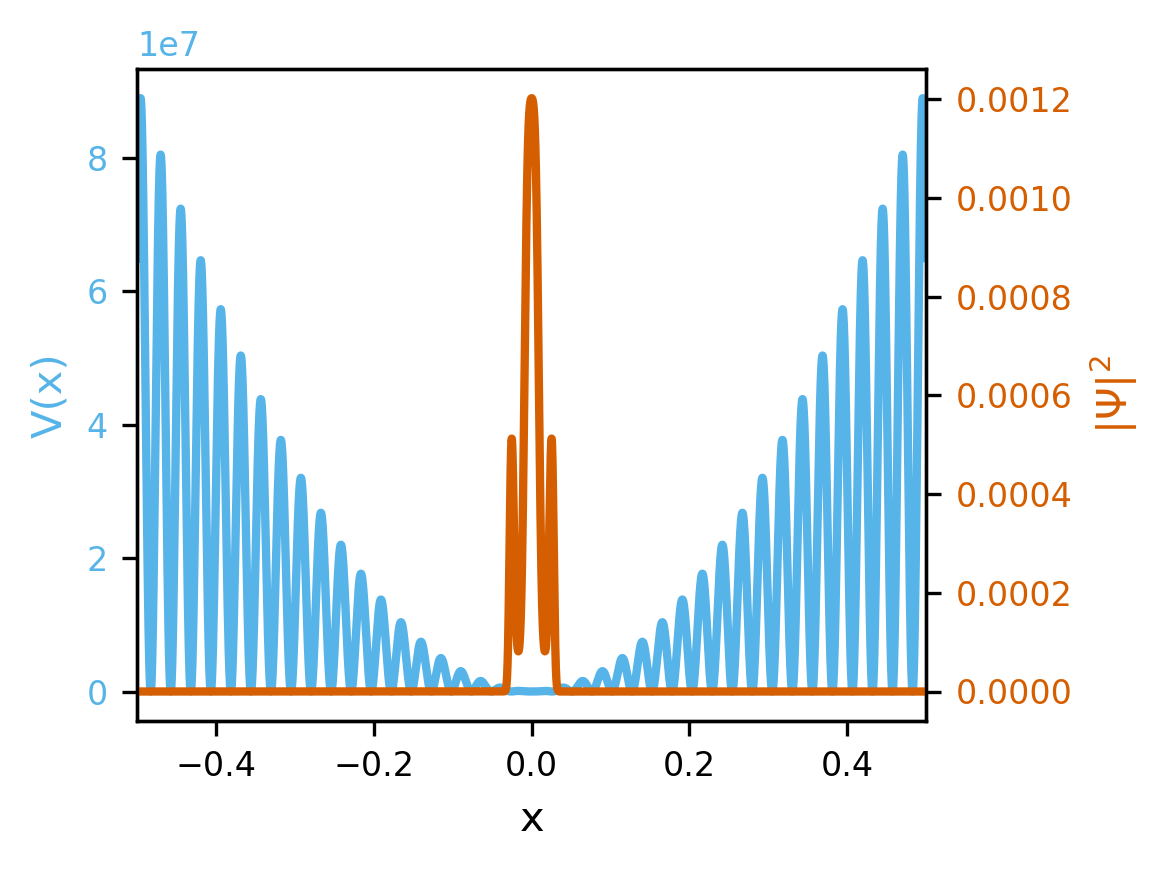

In [34]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z, sys_params['initial_trap'](z), color=ok['blue'])
ax1.set_xlabel('x')
ax1.set_xlim(z[0], z[-1])
ax2=ax1.twinx()
ax2.plot(z, density, color=ok['red'])
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V(x)', color=ok['blue'])
#ax1.set_ylim(0, 120)
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylabel('$|\\Psi|^2$', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_InitState_inPotential_{test_field_tag}.pdf')
plt.show()

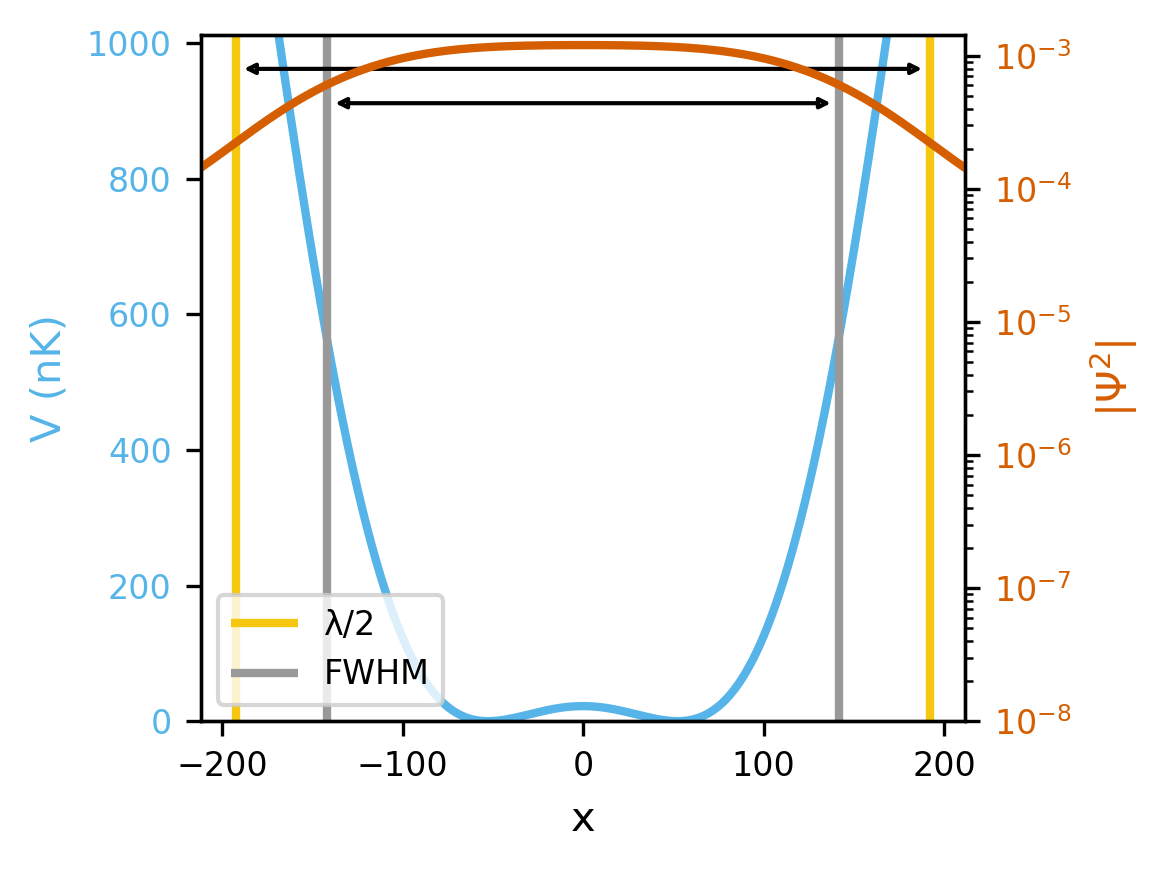

In [35]:
plot_max = 1.1 * gpe.convert_energy(E, -9)

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z_nano, gpe.convert_energy(sys_params['initial_trap'](z), -9), color=ok['blue'])
#ax1.plot(z, np.abs(Phi(z, max(k), amplitude = ampl, phase=0)) ** 2, '--', color=ok['orange'])

ax1.vlines([-λ_min/4, λ_min/4], 0, plot_max, color=ok['amber'], label='λ/2')
ax1.vlines(gpe.convert_x(x_width, -9), 0, plot_max, color=ok['grey'], label='FWHM')
#ax1.hlines(gpe.convert_energy(E, -9), gpe.convert_x(z[0], -6), gpe.convert_x(z[-1], -6), linestyle='--', color=ok['navy'], label='BEC Energy')
ax1.add_patch(patches.FancyArrowPatch((-λ_min/4, 0.95*plot_max), (λ_min/4, 0.95*plot_max), arrowstyle='<|-|>', mutation_scale=5)).set_zorder(3)
ax1.add_patch(patches.FancyArrowPatch(
    (gpe.convert_x(x_width[0], -9), 0.9*plot_max), 
    (gpe.convert_x(x_width[1], -9), 0.9*plot_max), 
    arrowstyle='<|-|>', mutation_scale=5)).set_zorder(4)
#for _ in range(n_peaks-1):
#    ax1.add_patch(patches.FancyArrowPatch((peak_locations[_], 0.9*plot_max), (peak_locations[_+1], 0.9*plot_max), arrowstyle='<|-|>', mutation_scale=5))
ax1.set_xlabel('x')
ax1.set_xlim(-1.1*λ_min/4, 1.1*λ_min/4)
ax2=ax1.twinx()
ax2.semilogy(z_nano, density, color=ok['red'])
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V (nK)', color=ok['blue'])
ax1.set_ylim(0, plot_max)
ax1.tick_params('y', labelcolor=ok['blue'])
legend1 = ax1.legend(loc='lower left')
legend1.remove()
ax2.set_ylim(1e-8, 1.2*density.max())
ax2.set_ylabel('|$\\Psi^2$|', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
ax2.add_artist(legend1)
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_ConfinementDemo_{test_field_tag}_Log.pdf')
plt.show()

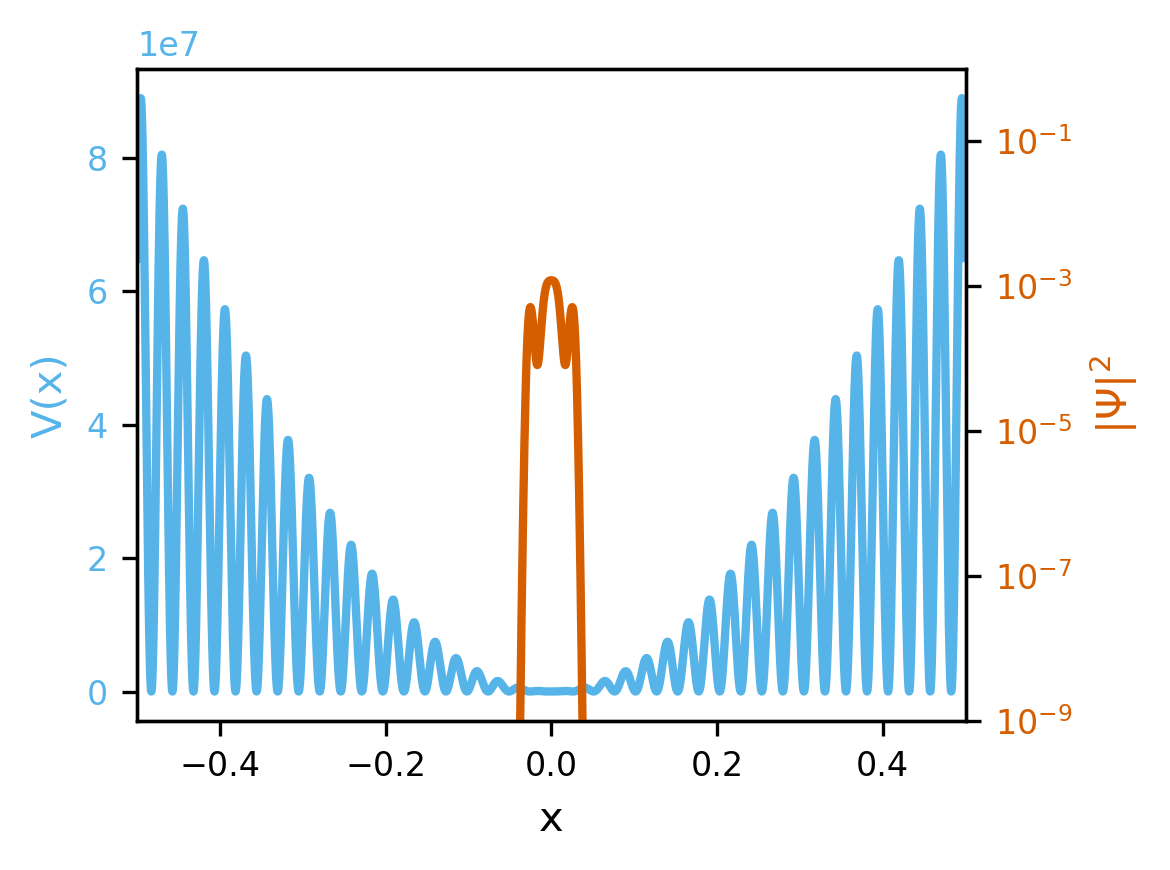

In [36]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z, sys_params['initial_trap'](z), color=ok['blue'])
ax1.set_xlabel('x')
ax1.set_xlim(z[0], z[-1])
ax2=ax1.twinx()
ax2.vlines([-λ_min/2, λ_min/2], 0, 1, color=ok['amber'], linestyle='--')
ax2.semilogy(z, density, color=ok['red'])
ax2.set_ylim(10**-9, 1)
#ax2.plot(x, UnivariateSpline(z, density, s=0)(x), color=ok['orange'])
ax1.set_ylabel('V(x)', color=ok['blue'])
#ax1.set_ylim(0, 120)
ax1.tick_params('y', labelcolor=ok['blue'])
ax2.set_ylabel('$|\\Psi|^2$', color=ok['red'])
ax2.tick_params('y', labelcolor=ok['red'])
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_InitState_inPotential_semilogy_{test_field_tag}.pdf')
plt.show()

In [37]:
exp2_z = np.sum(density * z) ** 2
exp_z2 = np.sum(density * z ** 2)

var = exp_z2 - exp2_z

print(f'The variance is {var}')
print(f'The FWHM of the density is {width}')
print(f'The confinement limit is half the field wavelength: {0.5 * λ_min}')
print(f'The confinement limit is the halved potential wavelength: {λ_min / 4}')

The variance is 0.00018461060623146892
The FWHM of the density is 0.01861572265625
The confinement limit is half the field wavelength: 385.0
The confinement limit is the halved potential wavelength: 192.5


In [38]:
print(f' wavelengths are : {λ_control} nm')

 wavelengths are : [770 780] nm


## Old Code below here in case it becomes useful again